# Udacity Machine Learning Nanodegree Capstone Project

Analysis of kaggle competition for [renthop.com apartment listing data](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries).

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

The train and test data sets are stored in json format. Import the data and convert it to pandas dataframes. Image data is handled later.

In [219]:
import json

with open('renthop_train.json') as json_data:
    data_json = json.load(json_data)
    
df_raw = pd.DataFrame.from_records(data_json)
df_raw["created"] = pd.to_datetime(df_raw["created"]) #changes feature to datetime, can access various elements easier in datetime format

'''with open('renthop_test.json') as json_data:
    test_data_json = json.load(json_data)
    
df_test = pd.DataFrame.from_records(test_data_json)'''

df_raw.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


### Benchmark model: 
Predicts percentage of low, medium, high interest based on overall rates. Standard of comparison when exploring data and creating models.

In [68]:
interest_counts = df_raw['interest_level'].value_counts()
print(interest_counts)
x = df_raw['interest_level'].value_counts().index.tolist()
total_records = float(len(df_raw))
benchmark_dict = {}
for i in range(len(x)):
    benchmark_dict[x[i]] = float(interest_counts[i])/total_records
    
print(benchmark_dict)

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64
{'low': 0.6946830928837737, 'medium': 0.22752877289674178, 'high': 0.07778813421948452}


## 1. Feature Analysis, Extraction, and Transformation
In general, no outliers removed or modified. Even obviously mistaken entries can have predictive power on interest level as it can be an indicator of a poorly created apartment listing. Brief overview: <br/>
* 'bathrooms': no change <br/>
* 'bedrooms': no change and added a feature that modified 0 bedroom entries (studio apartment) to roughly .83 <br/>
* 'building_id': removed and replaced with counts that id shows up in data and results of the other listings <br/>
* 'created': added features for hour, day of week, day of month, and month <br/>
* 'description': removed and replaced with length of description feature <br/>
* 'display_address': removed as location is provided by latitude and longitude <br/>
* 'features': removed and replaced by length of number of features and one hot encoding of the 10 most popular features <br/>
* 'interest_level': target variable <br/>
* 'latitude/longitude': no change <br/>
* 'listing_id': removed <br/>
* 'manager_id': removed and replaced with counts that id shows up in data and results of the other listings <br/>
* 'photos': removed and replaced by count of number of photos for that listing <br/>
* 'price': no change and also added another field that also shows the price_per_bed <br/>
* 'street_address': removed as location is provided by latitude and longitude <br/>


### 1.1 Bathrooms, Bedrooms, and Price
Analysis of bathrooms led me to decide to keep almost all the outliers. In a way you could see 0 bathroom entries as an outlier or mistaken data entry. There is no 0 option bathroom button to click when making or searching for a listing on the renthop.com website. In looking at the descriptions of 0 bathroom listings, they do not appear to be the type of apartments that do not have any bathrooms. 0 bathroom entries are most likely a mistaken entry. In some data sets I would argue for excluding the 0 bathroom entries but here I think it makes sense to keep them. By comparing the interest count of 0 bathroom entries to the benchmark rate, 0 bathroom entries skew more heavily towards low interest. While a 0 bathroom entry may be a mistake or nonsense, it has a real effect on interest level and should be left in. Sloppy and unusual entries in many input features show a similar trend. Rather than eliminate them from the training set, it makes more sense to let them remain and be used to help predict interest level.

In [69]:
df_numeric = pd.DataFrame( {'bathrooms': df_raw['bathrooms'],'bedrooms':df_raw['bedrooms'],'price':df_raw['price']})
df_numeric.describe()

,bathrooms,bedrooms,price
count,49352.00000,49352.000000,4.935200e+04
mean,1.21218,1.541640,3.830174e+03
std,0.50142,1.115018,2.206687e+04
min,0.00000,0.000000,4.300000e+01
25%,1.00000,1.000000,2.500000e+03
50%,1.00000,1.000000,3.150000e+03
75%,1.00000,2.000000,4.100000e+03
max,10.00000,8.000000,4.490000e+06


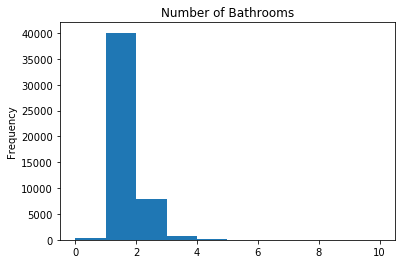

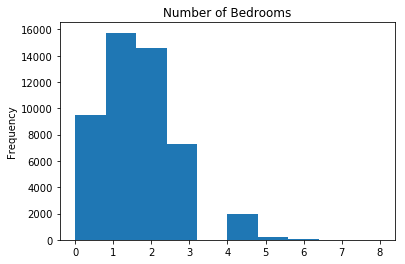

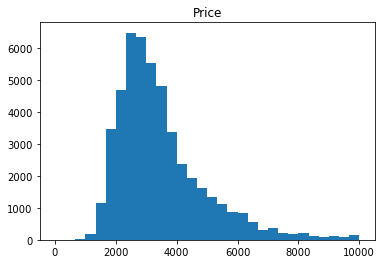

In [42]:
plt.figure(1)
plt.title("Number of Bathrooms")
df_raw['bathrooms'].plot(kind='hist')

plt.figure(2)
plt.title("Number of Bedrooms")
df_raw['bedrooms'].plot(kind='hist')

plt.figure(3)
plt.title("Price")
n, bins, patches = plt.hist(df_raw['price'], 30, range=[0,10000])
plt.show()

Outlier analysis. Due to the reasons listed above, I decided to keep all bathroom and bedroom outliers. Using the 1.5 IQR range, about 20% of bathroom entries are outliers (basically anything not 1 bathroom) and 5% of bedroom entries are outliers.

In [25]:
#outlier tests
from IPython.display import display 

def find_outliers(df,iqr_range):
    # For each feature find the data points with extreme high or low values
    for feature in df.keys():
        #Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        #Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        #Use the interquartile range to calculate an outlier step
        step = (Q3-Q1)*iqr_range
        if step == 0:
            step = np.std(df[feature]) * iqr_range
        # Display the outliers
        print ("Data points considered outliers for the feature '{}':".format(feature))
        display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
        
find_outliers(df_numeric,1.5)

Data points considered outliers for the feature 'bathrooms':


,bathrooms,bedrooms,price
100014,2.0,4,7995
100020,2.0,1,5645
100027,2.0,4,5800
100048,2.0,2,6895
10007,2.0,4,7400
100071,3.5,4,7500
100081,2.0,2,5600
100099,2.0,2,6500
100102,3.0,4,15000
100136,2.0,2,2100


Data points considered outliers for the feature 'bedrooms':


,bathrooms,bedrooms,price
100013,1.0,4,3350
100014,2.0,4,7995
100027,2.0,4,5800
100055,1.0,4,5000
10007,2.0,4,7400
100071,3.5,4,7500
100102,3.0,4,15000
100203,3.5,4,13500
100265,2.0,4,5300
100274,2.0,4,5900


Data points considered outliers for the feature 'price':


,bathrooms,bedrooms,price
100014,2.0,4,7995
100048,2.0,2,6895
10007,2.0,4,7400
100071,3.5,4,7500
100102,3.0,4,15000
100182,2.0,2,7800
100184,2.0,2,7000
100203,3.5,4,13500
100310,2.0,1,8400
100324,1.0,3,13500


Looking at the description for 0 bedroom entries and the renthop.com website showed that 0 bedroom is the indicator for a studio apartment. Roughly 20% of the data is labelled as 0 bedrooms, further indicating that this is an intentional designation and not a mistaken entry like 0 bathroom.

In [77]:
print(len(df_numeric[df_numeric['bedrooms'] == 0] ))
print(df_raw['description'][df_raw['bedrooms'] == 0][1:20,])

9475
100051    Stunning  full renovated studio unit. High cei...
100083    Enjoy the Upper West Side life-style!  This ap...
100096    Location: 141st St. and Malcolm X BlvdSubway: ...
100098    Located in one of Manhattan's most desirable a...
10010     Prime Location!! This Luxury Chelsea building ...
100107    Wonderful Upper East Side location! This quiet...
100112    Modern postwar building located in the heart o...
100117    Great gut -renovated apartment in charming ele...
100131    Located in a beautiful and classic pre-war bui...
100133    BRAND NEW JR 1 BEDROOM -- GRANITE KITCHEN -- M...
100138                                                     
100144    **No Fee**Second Month Free**East 55th Street*...
100188            Check Out This Lovely Studio Apartment...
1002      (((Spacious 2 bedroom in the Upper East Side))...
100206    Loft, High Ceilings, Hardwood, LightHuge Studi...
100213                                                     
100245    Spacious Studio in UES. A

About 300 entries are labelled as 0 bathroom. The descriptions do not make them seem like they are the type of apartments that do not have a bathroom. The number of blank entries in the description further supports that the 0 bathroom entries are sloppy entries.

In [78]:
print(len(df_numeric[df_numeric['bathrooms'] == 0] ))
print(df_raw['description'][df_raw['bathrooms'] == 0][1:20,])

313
100644    Sky high views with extra high ceiling! This c...
100660    Enjoy the great restaurants, clubs, boutiques ...
101007            Upper West Side-1 BER- Doorman, Elevat...
101068    Amidst the vibrant energy of the West Village ...
101520    SpaciousA StudioA Apartment in Modern New Deve...
101936                                                     
10208                              <p><a  website_redacted 
10298             This is a fantastic 1 bedroom penthous...
103076            West Village Studio.  Amenities: 24hr ...
103605    This doorman building in the heart of Murray H...
10404             NO FEE!!!<br /><br />This building is ...
104363                                                     
10438                                                      
104598    NO FEE PLUS 1 MONTH FREE!!!.. LISTING PRICE IS...
104821                                                     
105507    New Renovation! Upper Level LoftListed on the ...
106808    Featuring high-end ameniti

By comparing the 0 bedroom and 0 bathroom entries to the benchmark model, you can see that 0 bedroom entries are in line with standard entries while 0 bathroom entries tend to be low interest listings.

In [39]:
print("Benchmark: ", benchmark_dict)
print("0 Bathroom Entries")
print(df_raw[df_raw['bathrooms'] == 0]['interest_level'].value_counts())
print(df_raw[df_raw['bathrooms'] == 0]['interest_level'].value_counts()/
      float(len(df_raw[df_raw['bathrooms'] == 0]['interest_level'])))
print("0 Bedroom Entries")
print(df_raw[df_raw['bedrooms'] == 0]['interest_level'].value_counts())
print(df_raw[df_raw['bedrooms'] == 0]['interest_level'].value_counts()/
      float(len(df_raw[df_raw['bedrooms'] == 0]['interest_level'])))

Benchmark:  {'medium': 0.22752877289674178, 'high': 0.07778813421948452, 'low': 0.6946830928837737}
0 Bathroom Entries
low       306
medium      6
high        1
Name: interest_level, dtype: int64
low       0.977636
medium    0.019169
high      0.003195
Name: interest_level, dtype: float64
0 Bedroom Entries
low       6518
medium    2110
high       847
Name: interest_level, dtype: int64
low       0.687916
medium    0.222691
high      0.089393
Name: interest_level, dtype: float64


In the abstract, renting an apartment is paying money for an amount of space in a location. The number of bedrooms is a rough proxy for that amount of space. However the the gap between 0 (studio apartments) to 1 (one bedroom) is not on the same scale as from 1 bedroom to 2 bedrooms. By looking at price, how similar is a studio apartment to a one bedroom? I want to use that number in order to create a feature that better captures the 'amount of space' and also to come up with a 'price per bedroom' feature. By using the median price of 0 bedroom and 1 bedroom listings, I approximate that number as 0.828 and create a new input feature that replaces 0 bedroom with 0.828 bedroom.

In [70]:
print("0 Bedroom Median: ",df_raw[df_raw['bedrooms'] == 0]['price'].median())
print("1 Bedroom Median: ",df_raw[df_raw['bedrooms'] == 1]['price'].median())
studio_bedroom = round(df_numeric[df_numeric['bedrooms'] == 0]['price'].median()
                       /df_numeric[df_numeric['bedrooms'] == 1]['price'].median(),3)
print("Studio Bedroom Approx: ",studio_bedroom)
mod_bed = pd.Series(df_numeric['bedrooms'])
mod_bed[mod_bed == 0] = studio_bedroom
df_raw['bedrooms_modified'] = pd.Series(mod_bed,index=df_raw.index)

0 Bedroom Median:  2400.0
1 Bedroom Median:  2900.0
Studio Bedroom Approx:  0.828


### Price and Outliers
Unlike bedrooms and bathrooms, some of the price outliers are so extreme that they drastically change the variance of the data. These outliers are either mistaken entries or so outlandish as to not be applicable to most entries. On one hand, there is value in not changing them (like 0 bathroom entries) as they may indicate sloppy listings. On the other hand, price for space in a location is an important feature of real estate and including the extreme prices can skew that important principal. Thus a compromise: rather than removing the outliers I skewed them to a less extreme value. This allows the model to see them as an extreme value while still not exercising undo leverage on the price feature. By changing the 16 entries, the standard deviation is reduced by an order of magnitude from roughly 22000 to 2400.

In [55]:
print(len(df_numeric[df_numeric['price'] > 100000] ))
print(len(df_numeric[df_numeric['price'] > 50000] ))
print(len(df_numeric[df_numeric['price'] > 20000] ))
print(len(df_numeric[df_numeric['price'] > 10000] ))

6
16
109
878


In [71]:
price_modified = pd.Series(df_numeric['price'])
price_modified[price_modified >= 50000] = 50000
print(price_modified.describe())
print(df_raw['price'].describe())

count    49352.000000
mean      3669.929365
std       2373.377579
min         43.000000
25%       2500.000000
50%       3150.000000
75%       4100.000000
max      50000.000000
Name: price, dtype: float64
count    4.935200e+04
mean     3.830174e+03
std      2.206687e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64


Add two features: price modified and price per bed.

In [72]:
per_bed = pd.Series(price_modified/mod_bed)
df_raw['price_modified'] = pd.Series(price_modified,index=df_raw.index)
df_raw['price_per_bed'] = pd.Series(per_bed,index=df_raw.index)

In [74]:
#df_raw.describe()
#df_raw.to_pickle("train_checkpoint_11")

Some exploration of the price_per_bed feature. Note the drop off in high interest level listings as the price-per-bed value gets large.

count    49352.000000
mean      2449.795559
std       1292.908132
min         51.932367
25%       1600.000000
50%       2294.685990
75%       3097.500000
max      60386.473430
Name: price_per_bed, dtype: float64


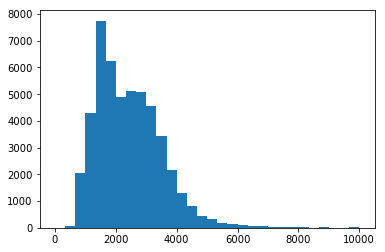

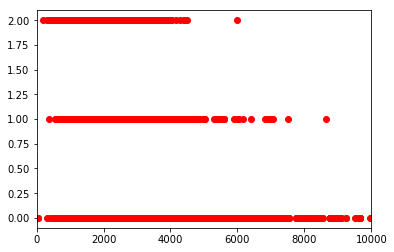

In [70]:
print(df_raw['price_per_bed'].describe())
plt.figure(1)
n, bins, patches = plt.hist(df_raw['price_per_bed'], 30, range=[0,10000])
plt.show()
plt.figure(2)
plt.plot(df_raw['price_per_bed'],df_raw['interest_level'].map({'low':0,'medium':1,'high':2}),'ro')
plt.xlim([0,10000])
plt.show()

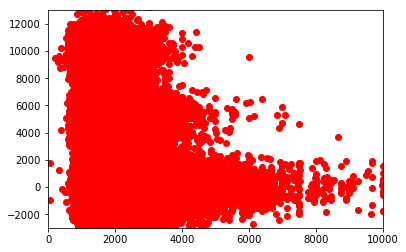

In [75]:
import random

temp_plot = []

for x in df_raw['interest_level']:
    if x == 'low':
        temp_plot.append(random.gauss(0,1000))
    elif x == 'medium':
        temp_plot.append(random.gauss(5000,1000))
    else:
        temp_plot.append(random.gauss(10000,1000))
        
plt.plot(df_raw['price_per_bed'],temp_plot,'ro')
plt.xlim([0,10000])
plt.ylim([-3000,13000])
plt.show()

### 1.2 Created
Created is a datetime of when the listing was created. Exploration of the training and test data shows that all listings were created between April 1st and June 30th of 2016. Cursory examination of data shows that time of day, day of week, date of month, and month appear to influence interest levels. This makes sense as viewing an apartment listing would be preferable for certain times, days, and parts of the month. Thus the creation of four new features (month, hour, day of week, and day of month).

In [79]:
print(np.min(df_raw['created']))
print(np.max(df_raw['created']))

2016-04-01 22:12:41
2016-06-29 21:41:47


In [75]:
created_hour_list = []
created_dow_list = [] #0 is monday, 6 is sunday
created_day_list = []
created_month_list = []
for x in df_raw['created']:
    x_hour = x.hour
    x_minute = x.minute
    x_dow = x.dayofweek
    x_day = x.day
    x_month = x.month
    
    if x_minute > 30:
        x_hour += 1
        if x_hour > 23:
            x_hour = 0
    
    if x_day > 29: #only 1 month had a 31st day
        x_day = 30
        
    created_hour_list.append(x_hour)
    created_dow_list.append(x_dow)
    created_day_list.append(x_day)
    created_month_list.append(x_month)

df_raw['created_hour'] = pd.Series(created_hour_list, index=df_raw.index)
df_raw['created_dow'] = pd.Series(created_dow_list, index=df_raw.index)
df_raw['created_day'] = pd.Series(created_day_list, index=df_raw.index)
df_raw['created_month'] = pd.Series(created_month_list, index=df_raw.index)


In [77]:
#df_raw.head()
#df_raw.to_pickle("train_checkpoint_12")

In [95]:
print(benchmark_dict)
g2 = df_raw.groupby(['created_month', 'interest_level']).agg({'created_month': 'count'})
g3 = g2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
print(g3.to_string())
#print(g2.to_string())

{'medium': 0.22752877289674178, 'high': 0.07778813421948452, 'low': 0.6946830928837737}
                              created_month
created_month interest_level               
4             high                 7.763086
              low                 69.221863
              medium              23.015051
5             high                 7.811610
              low                 69.146040
              medium              23.042350
6             high                 7.763649
              low                 70.001167
              medium              22.235184


In [96]:
print(benchmark_dict)
g2 = df_raw.groupby(['created_dow', 'interest_level']).agg({'created_dow': 'count'})
g3 = g2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
print(g3.to_string())
#print(g2.to_string())

{'medium': 0.22752877289674178, 'high': 0.07778813421948452, 'low': 0.6946830928837737}
                            created_dow
created_dow interest_level             
0           high               7.973579
            low               69.143666
            medium            22.882755
1           high               7.508614
            low               69.252703
            medium            23.238684
2           high               7.669429
            low               70.214574
            medium            22.115997
3           high               7.773032
            low               69.212935
            medium            23.014033
4           high               8.547346
            low               66.350586
            medium            25.102068
5           high               7.334963
            low               71.292967
            medium            21.372070
6           high               7.729575
            low               71.504074
            medium            20

In [97]:
print(benchmark_dict)
g2 = df_raw.groupby(['created_day', 'interest_level']).agg({'created_day': 'count'})
g3 = g2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
print(g3.to_string())
#print(g2.to_string())

{'medium': 0.22752877289674178, 'high': 0.07778813421948452, 'low': 0.6946830928837737}
                            created_day
created_day interest_level             
1           high              11.409396
            low               60.850112
            medium            27.740492
2           high               8.917555
            low               65.787998
            medium            25.294448
3           high               8.374931
            low               67.886855
            medium            23.738214
4           high               7.903550
            low               69.524447
            medium            22.572003
5           high              10.232301
            low               63.329646
            medium            26.438053
6           high               8.535927
            low               67.855213
            medium            23.608860
7           high               9.693878
            low               67.006803
            medium            23

Unsure on how to handle the created_hour data. Some hours have very few submitted entries while some are abnormally large. Due to the large number of entries down in the very early hours of the day, I wonder if renthop either aggregated data from other sources or companies that do the listings transmit their data at a scheduled time in the early hours.

In [99]:
print(benchmark_dict)
g1 = df_raw.groupby(['created_hour']).agg({'created_hour': 'count'})
g2 = df_raw.groupby(['created_hour', 'interest_level']).agg({'created_hour': 'count'})
g3 = g2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
print(g1)
print(g3.to_string())
#print(g2.to_string())


{'medium': 0.22752877289674178, 'high': 0.07778813421948452, 'low': 0.6946830928837737}
              created_hour
created_hour              
0                       61
1                     3637
2                     7219
3                    10600
4                     5882
5                     6047
6                     7484
7                     1888
8                      674
9                      127
10                     187
11                     372
12                     530
13                     677
14                     787
15                     682
16                     610
17                     419
18                     439
19                     391
20                     173
21                     180
22                     178
23                     108
                             created_hour
created_hour interest_level              
0            high               27.868852
             low                40.983607
             medium             31.147541


### 1.3 Description
A new feature caused description_length (length of the description in characters) was created and used in preliminary analysis.

count    49352.000000
mean       601.975624
std        393.592337
min          0.000000
25%        340.000000
50%        564.000000
75%        809.000000
max       4466.000000
Name: description_length, dtype: float64


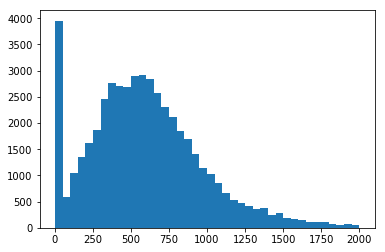

In [258]:
df_raw['description_length'] = pd.Series(df_raw['description'].str.len(), index=df_raw.index)
print(df_raw['description_length'].describe())
plt.hist(df_raw['description_length'],40, range=[0,2000])
plt.show()

In [261]:
print(benchmark_dict)
g1 = df_raw.groupby(['description_length']).agg({'description_length': 'count'})
g2 = df_raw.groupby(['description_length', 'interest_level']).agg({'description_length': 'count'})
g3 = g2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
print(g1)
print(g3.to_string())

{'medium': 0.22752877289674178, 'low': 0.6946830928837737, 'high': 0.07778813421948452}
                    description_length
description_length                    
0                                 1446
1                                  240
5                                    1
8                                 1647
9                                    4
10                                   1
11                                   5
12                                   2
13                                   7
14                                   6
15                                   5
16                                   5
17                                   5
18                                   2
19                                   6
20                                   5
21                                   6
22                                   3
23                                   6
24                                 335
25                                   7
26             

In [81]:
#df_raw.head()
df_raw.to_pickle("train_checkpoint_13")

### 1.4 Display Address and Street Address
Both features are ignored. I use the latitude and longitude for the location. Display address and Street address filled in for every entry. I considered creating a feature using the count of the number of times each entry appeared but decided against it as what I do with building_id more accuratly captures that information.

### 1.5 Apartment Features
Each apartment feature entry contains a list of all features submitted for that apartment. There is no standardization to the features thus some features try to convey the same information with different spellings ("Pre-war","pre war", etc). There are 1556 different features. The top 10 features show up 9,000 or more times. Keywords can be used in an attempt to consolidate similar features. I created 11 new input features based on the apartment features: 1 that has the total number of features in the listing and 10 binary features for the presence/absence of one of the 10 most listed features.

In [82]:
df_features = pd.DataFrame( {'listing_id': df_raw['listing_id'],'features':df_raw['features']})
df_features.head()

,features,listing_id
10,[],7211212
10000,"[Doorman, Elevator, Fitness Center, Cats Allow...",7150865
100004,"[Laundry In Building, Dishwasher, Hardwood Flo...",6887163
100007,"[Hardwood Floors, No Fee]",6888711
100013,[Pre-War],6934781


In [83]:
feature_list = []
feature_list_count = []
for x in df_features['features']:
    feature_list_count.append(len(x))
    for y in x:
        if y not in feature_list:
            feature_list.append(y)
            
print("Number of different features: ",len(feature_list))

#add count of features to df_raw
df_raw['features_count'] = pd.Series(feature_list_count, index=df_raw.index)
#print(len(feature_count))
#print(len(df_features['features']))

Number of different features:  1556


In [107]:
print(benchmark_dict)
g1 = df_raw.groupby(['features_count']).agg({'features_count': 'count'})
g2 = df_raw.groupby(['features_count', 'interest_level']).agg({'features_count': 'count'})
g3 = g2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
print(g1.to_string())
print(g3.to_string())
#print(g2.to_string())

{'medium': 0.22752877289674178, 'high': 0.07778813421948452, 'low': 0.6946830928837737}
                features_count
features_count                
0                         3218
1                         4340
2                         4938
3                         6211
4                         5459
5                         4547
6                         3835
7                         3374
8                         2840
9                         2453
10                        2217
11                        1681
12                        1377
13                        1009
14                         737
15                         456
16                         283
17                         161
18                          89
19                          45
20                          24
21                          14
22                          13
23                           6
24                           5
25                           2
26                           8
27           

1556 features. Creating a Counter object shows that the 10 most common show up at least 9,000 times. Also saved the features to a csv to check some of the keywords.

In [108]:
from collections import Counter
feature_flat = []

for x in df_features['features']:
    for y in x:
        feature_flat.append(y)
            
feature_count = Counter(feature_flat)
print(feature_count)

Counter({'Elevator': 25915, 'Cats Allowed': 23540, 'Hardwood Floors': 23527, 'Dogs Allowed': 22035, 'Doorman': 20898, 'Dishwasher': 20426, 'No Fee': 18062, 'Laundry in Building': 16344, 'Fitness Center': 13252, 'Pre-War': 9148, 'Laundry in Unit': 8738, 'Roof Deck': 6542, 'Outdoor Space': 5268, 'Dining Room': 5136, 'High Speed Internet': 4299, 'Balcony': 2992, 'Swimming Pool': 2730, 'Laundry In Building': 2593, 'New Construction': 2559, 'Terrace': 2283, 'Exclusive': 2167, 'Loft': 2100, 'Garden/Patio': 1943, 'Wheelchair Access': 1358, 'Common Outdoor Space': 1293, 'HARDWOOD': 914, 'Fireplace': 912, 'SIMPLEX': 908, 'prewar': 855, 'LOWRISE': 789, 'Garage': 745, 'Laundry Room': 719, 'Reduced Fee': 699, 'Laundry In Unit': 697, 'Furnished': 689, 'Multi-Level': 622, 'Private Outdoor Space': 508, 'Prewar': 494, 'PublicOutdoor': 423, 'Parking Space': 418, 'Roof-deck': 397, 'dishwasher': 378, 'High Ceilings': 362, 'elevator': 357, 'Renovated': 323, 'Pool': 282, 'LAUNDRY': 256, 'Green Building': 2

In [109]:
import csv

with open('kaggle_apt_feature_dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in feature_count.items():
        writer.writerow([key, value])


Setting up 10 one hot encoded variables based on the 10 most popular features. Search terms for each of the 10 features: <br/>
elevator <br/>
cats<br/>
hardwood<br/>
dogs<br/>
doorman<br/>
dishwasher<br/>
no fee<br/>
laundry<br/>
fitness, gym<br/>
pre-war, prewar, pre war

In [84]:
apt_feature_length = len(df_raw['features'])
apt_feature_array = np.zeros([apt_feature_length, 10])
#print(apt_feature_array.shape)
apt_feature_search_string = [["elevator"],["cats"],["hardwood"],["dogs"],["doorman"],["dishwasher"],
                             ["no fee"],["laundry"],["fitness","gym"],["pre-war","prewar","pre war"]]
z_break = 0
for i in range(apt_feature_length):
    feature_list = df_raw['features'].iloc[i]
    for feature in feature_list:
        temp_feature = feature.lower()
        #print(i, temp_feature)
        for j in range(10):#search_category in apt_feature_search_string:
            search_category = apt_feature_search_string[j]
            for search_string in search_category:
                if search_string in temp_feature:
                    apt_feature_array[i,j] = 1
                    break

print(apt_feature_array[0:4,:])
                

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.  0.  0.]]


In [85]:
#add the one hot variables to the dataframe
z_string = "apt_feature_"
for i in range(10):
    temp_string = z_string + apt_feature_search_string[i][0]
    #print(temp_string)
    df_raw[temp_string] = pd.Series(apt_feature_array[:,i],index=df_raw.index)

In [90]:
#df_raw.head()
#df_raw['features_count'].describe()
#df_raw.to_pickle("train_checkpoint_15")

### 1.7 Listing Id
Not used.

### 1.8 Manager Id and Building Id

Manager_id and building_id have too many unique values (roughly 3,500 and 7,500) to one hot encode. However, when analyzing the test set, it would be useful to know if the manager_id and building_id have been used before and what the past results were. Since managers likely have a similar system for creating entries and buildings have similar desirable (or undesirable) attributes, I created 4 features for each: count of listings and count of high/medium/low interest listings. For each entry I subtracted the result of that apartment interest level in order not to influence the predictions (ie for a manager with only 1 entry, the count of high/medium/low would predict the interest level 100% of the time, thus I have to remove the prediction for that entry, from that entry row). <br/>

I considered adding other columns that had the proportion of low/medium/high interest % listings modified by how certain I am that those percentages are different than the benchmark percentage. The thinking being if a manager produces 50% high interest listings over 200 samples, he's likely doing something statistically signficant and that could be used to improve the rating. However I could not think of a good way to produce those percentages. Simply calculating the observed percentages produces issues with small sample size and I could not think of a Laplacian smoothing like procedure that would work in this case. I considered a one-proportion z-test (https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) but most manager samples lack sufficient number of samples. I feel like Bayes Theorem could be applied here or a probability density but could not come up with a good way to apply my thoughts to manager_id and building_id.

In [91]:
count = Counter(df_raw['manager_id'])
df_manager = pd.DataFrame.from_dict(count, orient='index').reset_index()
df_manager = df_manager.rename(columns={'index':'manager_id', 0:'count'})
df_manager.describe()

,count
count,3481.000000
mean,14.177535
std,53.045270
min,1.000000
25%,1.000000
50%,4.000000
75%,13.000000
max,2533.000000


In [92]:
low_count = []
medium_count = []
high_count = []

df_temp = pd.DataFrame( {'manager_id': df_raw['manager_id'],'interest_level':df_raw['interest_level']})

for x in df_manager['manager_id']:
    subset = df_temp[(df_temp['manager_id'] == x)]
    low_count.append(len(subset[subset['interest_level'] == 'low']))
    medium_count.append(len(subset[subset['interest_level'] == 'medium']))
    high_count.append(len(subset[subset['interest_level'] == 'high']))
    
df_manager['low_count'] = pd.Series(low_count,index=df_manager.index)
df_manager['medium_count'] = pd.Series(medium_count,index=df_manager.index)
df_manager['high_count'] = pd.Series(high_count,index=df_manager.index)

df_manager = df_manager.rename(columns={ 'count':'manager_count', 'low_count':'manager_low','medium_count':'manager_medium'
                          ,'high_count':'manager_high'})

In [123]:
df_manager.head()

,manager_id,manager_count,manager_low,manager_medium,manager_high
0,812d39efccb575c6ece9dc21d777cfa8,1,0,1,0
1,c53e54425cc299b2017c5e84f1614d28,1,1,0,0
2,6e249f377fd507282ab0caa8976fff46,39,36,3,0
3,01c92a064394eb8fd1a084631c8bc701,1,1,0,0
4,65a2ad830b1c49ed8cc2520d56beff86,7,6,1,0


Some histograms that show that more experienced managers tend to have a lower rate of low interest listings and a higher rate of high interest listings.

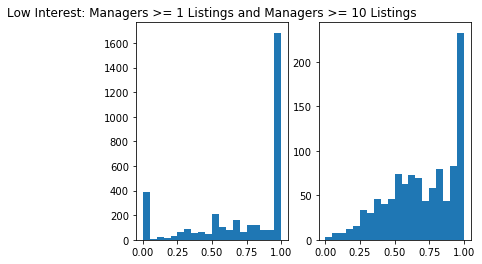

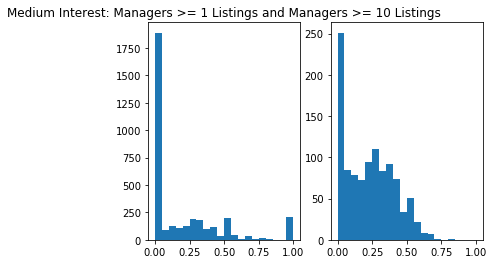

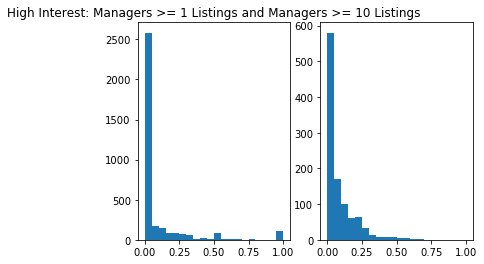

In [125]:
df_temp = df_manager[df_manager['manager_count'] >= 1]
df_temp_10 = df_manager[df_manager['manager_count'] >= 10]

low_proportion = df_temp['manager_low']/df_temp['manager_count']
medium_proportion = df_temp['manager_medium']/df_temp['manager_count']
high_proportion = df_temp['manager_high']/df_temp['manager_count']

low_proportion_10 = df_temp_10['manager_low']/df_temp_10['manager_count']
medium_proportion_10 = df_temp_10['manager_medium']/df_temp_10['manager_count']
high_proportion_10 = df_temp_10['manager_high']/df_temp_10['manager_count']

plt.figure(1)
f, (ax1, ax2) = plt.subplots(1, 2)
#ax1.plot(x, y)
ax1.hist(low_proportion, 20, range=[0,1])
ax1.set_title('Low Interest: Managers >= 1 Listings and Managers >= 10 Listings')
ax2.hist(low_proportion_10, 20, range=[0,1])

plt.figure(2)
f, (ax3, ax4) = plt.subplots(1, 2)
ax3.hist(medium_proportion, 20, range=[0,1])
ax3.set_title('Medium Interest: Managers >= 1 Listings and Managers >= 10 Listings')
ax4.hist(medium_proportion_10, 20, range=[0,1])

plt.figure(3)
f, (ax5, ax6) = plt.subplots(1, 2)
ax5.hist(high_proportion, 20, range=[0,1])
ax5.set_title('High Interest: Managers >= 1 Listings and Managers >= 10 Listings')
ax6.hist(high_proportion_10, 20, range=[0,1])

plt.show()

Can examine the most successful managers to get a sense of what they do in order to produce high interest listings.

In [127]:
print(df_manager[(df_manager["manager_count"] >= 10) & (df_manager["manager_high"]/df_manager["manager_count"] > 0.5 )])
print(df_raw[df_raw['manager_id'] == '12c0a30e296faa0dfd422fe918d7d4f4'])

                            manager_id  manager_count  manager_low  \
260   3e04672678ee02c7bb843a9d4641c440             17            6   
372   456848d13f96dc522e5cf381095caeca             31            3   
1504  e9920062e07ee893c10e38d0259665b0             27            2   
1974  3b630ec9cb6eee53b92cfac7f42e3bf4             29            4   
2195  cb91d4992adf2a996e1454fb39434fb8             12            2   
2372  f948a6d058c0d51c2b802734f5db9d74             11            0   
2497  12c0a30e296faa0dfd422fe918d7d4f4             91           12   
2501  603575a3da76fa757cd6451f3707819d             26            3   
2603  53072af31d51fcdbc29dba6bc28a5011             15            0   
2939  2529098e553450cef6ba3198a1c2eec4             12            0   
3354  c80aad40b6abd065b4aefee40a2154f6             15            1   
3418  35f11f952ba96803a9d9e23e83e7f972             46            4   

      manager_medium  manager_high  
260                2             9  
372            

In [99]:
count = Counter(df_raw['building_id'])
df_building = pd.DataFrame.from_dict(count, orient='index').reset_index()
df_building = df_building.rename(columns={'index':'building_id', 0:'count'})
print(df_building.describe())

             count
count  7585.000000
mean      6.506526
std      95.982172
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max    8286.000000


In [100]:
low_count = []
medium_count = []
high_count = []

df_temp = pd.DataFrame( {'building_id': df_raw['building_id'],'interest_level':df_raw['interest_level']})

for x in df_building['building_id']:
    subset = df_temp[(df_temp['building_id'] == x)]
    low_count.append(len(subset[subset['interest_level'] == 'low']))
    medium_count.append(len(subset[subset['interest_level'] == 'medium']))
    high_count.append(len(subset[subset['interest_level'] == 'high']))
    
df_building['low_count'] = pd.Series(low_count,index=df_building.index)
df_building['medium_count'] = pd.Series(medium_count,index=df_building.index)
df_building['high_count'] = pd.Series(high_count,index=df_building.index)

df_building = df_building.rename(columns={ 'count':'building_count', 'low_count':'building_low','medium_count':'building_medium'
                          ,'high_count':'building_high'})

In [101]:
df_building.head()

,building_id,building_count,building_low,building_medium,building_high
0,8fe78423f414e06b9c9ea3dca908cbf7,1,1,0,0
1,539c0e594529c138692772e44208992a,1,0,0,1
2,498df36f2cbe93ffbd6bd9320ecdb4eb,1,0,0,1
3,28c347c30620314c523b6716e4f387fb,1,1,0,0
4,e08fdf2850ac74107be94c1760432bde,1,1,0,0


In [103]:
#add data to df_raw
df_raw = df_raw.join(df_manager.set_index('manager_id'),on='manager_id')
df_raw = df_raw.join(df_building.set_index('building_id'),on='building_id')

In [105]:
#df_raw.columns.values
#df_raw.head()
#df_raw.describe()
#df_raw['features_count'].describe()
#df_raw.to_pickle("train_checkpoint_16")

For each row, have to remove the predictor for that row or the model will overfit. Ie for a manager with only 1 entry, the manager_low/medium/high tells the model what the answer is going to be so for each row need to remove the answer for that row.

In [106]:
row_length = len(df_raw['manager_id'])
#print( df_raw.get_value(df_raw.index[0],'manager_count'))
for i in range(row_length):
    interest_level = df_raw.get_value(df_raw.index[i],'interest_level')
    temp_string = 'manager_' + interest_level
    #print(df_raw.get_value(df_raw.index[i],'manager_count'),df_raw.get_value(df_raw.index[i],temp_string))
    z1 = df_raw.get_value(df_raw.index[i],'manager_count') - 1
    df_raw.set_value(df_raw.index[i],'manager_count',z1)
    z2 = df_raw.get_value(df_raw.index[i],temp_string) - 1
    df_raw.set_value(df_raw.index[i],temp_string,z2)    
    #print(df_raw.get_value(df_raw.index[i],'manager_count'),df_raw.get_value(df_raw.index[i],temp_string))
    
    temp_string = 'building_' + interest_level
    z1 = df_raw.get_value(df_raw.index[i],'building_count') - 1
    df_raw.set_value(df_raw.index[i],'building_count',z1)
    z2 = df_raw.get_value(df_raw.index[i],temp_string) - 1
    df_raw.set_value(df_raw.index[i],temp_string,z2) 
    #break
   

In [108]:
#df_raw.columns.values
#df_raw.head()
#df_raw.describe()
#df_raw['features_count'].describe()
#df_raw.to_pickle("train_checkpoint_18")

### 1.9 Photos
Around 70 Gb of photo data is available for the listings. The data is stored in a directory arranged by each listing_id. I created a feature that has the number of photos for each listing.

In [114]:
#sample code for creating the dictionary of counts
import os
import pickle

base_directory = '.../Kaggle_renthop_images/images' #not actual directory
image_list = os.listdir( base_directory)

image_dict = {}
for x in image_list:
    
    sub_directory = base_directory + "/" + str(x)
    if os.path.isdir(sub_directory):
        image_dict[x] = len( os.listdir(sub_directory))
        
pickle.dump( image_dict, open( "image_count_dict.p", "wb" ) ) #save it with pickle since will want it for test data

KeyboardInterrupt: 

count    49352.000000
mean         5.612680
std          3.633711
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         68.000000
Name: image_count, dtype: float64


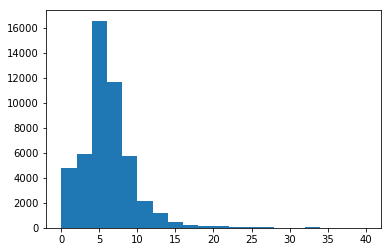

In [220]:
import pickle
image_dict = pickle.load( open( "image_count_dict.p", "rb" ) )

image_count = []
for x in df_raw['listing_id']:
    y = str(x)
    if y in image_dict:
        image_count.append(image_dict[y])
    else:
        image_count.append(0)
    
df_raw['image_count'] = pd.Series(image_count,index=df_raw.index)

print(df_raw['image_count'].describe())
plt.hist(df_raw['image_count'],20, range=[0,40])
plt.show()

In [227]:
print(benchmark_dict)
g1 = df_raw.groupby(['image_count']).agg({'image_count': 'count'})
g2 = df_raw.groupby(['image_count', 'interest_level']).agg({'image_count': 'count'})
g3 = g2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
#print(g1.to_string())
print(g3.to_string())
#print(g2.to_string())

{'medium': 0.22752877289674178, 'low': 0.6946830928837737, 'high': 0.07778813421948452}
                            image_count
image_count interest_level             
0           high               1.385809
            low               95.205100
            medium             3.409091
1           high               6.785411
            low               80.067854
            medium            13.146735
2           high               8.051166
            low               76.072235
            medium            15.876599
3           high               8.715697
            low               67.881449
            medium            23.402854
4           high               7.793033
            low               66.272565
            medium            25.934401
5           high               9.584481
            low               64.118457
            medium            26.297062
6           high               8.517913
            low               65.274268
            medium            26

In [111]:
#df_raw.columns.values
#df_raw.head()
#df_raw.describe()
#df_raw['features_count'].describe()
df_raw.to_pickle("train_checkpoint_19")

### 1.10 Latitude and Longitude
Shows the location of the apartment. An issue with this data is similar to the bathrooms and price dilemma discussed above. Some of the data is obviously wrong but obviously wrong submission have their own predictive value. Like the price data, I decided to limit the extreme outliers into more limited extremes.

In [117]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

loc_df = pd.DataFrame({'longitude':df_raw['longitude'],'latitude':df_raw['latitude']}) #'listing_id':df_raw['listing_id'],
print( loc_df.describe())

lat_range = 1.0
x_min, x_max = loc_df.describe()['longitude']['25%'] - lat_range, loc_df.describe()['longitude']['75%'] + lat_range
y_min, y_max = 	loc_df.describe()['latitude']['25%'] - lat_range, loc_df.describe()['latitude']['75%'] + lat_range

print('Extreme Lat/Long Count of Outliers')
print( len(loc_df[loc_df['longitude'] < x_min] ))
print( len(loc_df[loc_df['longitude'] > x_max] ))
print( len(loc_df[loc_df['latitude'] < y_min] ))
print( len(loc_df[loc_df['latitude'] > y_max] ))

loc_df = loc_df[(loc_df['latitude'] >= y_min) & (loc_df['latitude'] <= y_max) & 
                 (loc_df['longitude'] >= x_min) & (loc_df['longitude'] <= x_max) ]

print("Outliers Removed", loc_df.describe())

           latitude     longitude
count  49352.000000  49352.000000
mean      40.741545    -73.955716
std        0.638535      1.177912
min        0.000000   -118.271000
25%       40.728300    -73.991700
50%       40.751800    -73.977900
75%       40.774300    -73.954800
max       44.883500      0.000000
Extreme Lat/Long Count of Outliers
7
24
13
16
Outliers Removed            latitude     longitude
count  49319.000000  49319.000000
mean      40.750964    -73.972487
std        0.039985      0.030819
min       39.799600    -74.663700
25%       40.728300    -73.991700
50%       40.751800    -73.977900
75%       40.774300    -73.954800
max       41.086800    -73.204000


In the scatter plot, can mostly see the shape of NYC (hey there's Central Park) and notice the coverage of the five buroughs. Manhattan and Brooklyn are represented the most. Not much of Staten Island is represented.

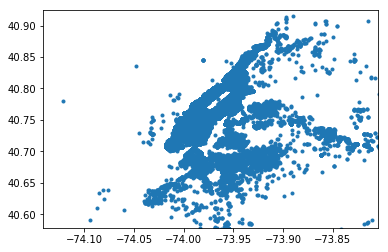

In [26]:
plt.plot(loc_df['longitude'],loc_df['latitude'],'.')
z1 = lat_range*.85
plt.xlim([x_min + z1,x_max -z1])
plt.ylim([y_min + z1,y_max -z1])
plt.show()

In [29]:
#fit the model
from sklearn import metrics

n_cluster_range = [2,3,4,5,6,7,9,12,15,20]
for x in n_cluster_range:
    kmeans = KMeans(n_clusters = x, random_state=0)
    kmeans.fit(loc_df)
    kmeans_pred = kmeans.predict(loc_df)

    score = metrics.silhouette_score(loc_df, kmeans_pred, metric='euclidean',sample_size=5000)
    print(x,score)


2 0.430142975047
3 0.462536995206
4 0.41993860184
5 0.444590289401
6 0.413698724972
7 0.43568479083
9 0.421432604323
12 0.451194861985
15 0.438334223761
20 0.482186668379


Choosing 5 as the number of clusters as NYC is divided into 5 buroughs and the silhouette scores are roughly in the same range.

In [30]:
kmeans = KMeans(n_clusters = 5, random_state=0)
kmeans.fit(loc_df)
kmeans_pred = kmeans.predict(loc_df)

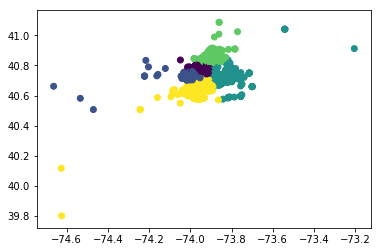

In [42]:
plt.scatter(loc_df['longitude'],loc_df['latitude'],c=kmeans_pred)
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1]) #,marker='D'
plt.show()

Plots by interest level.

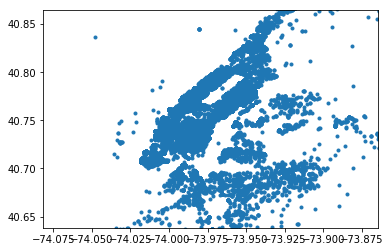

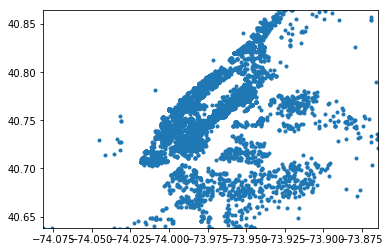

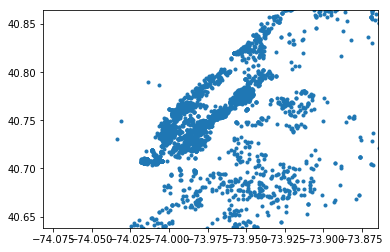

In [44]:
constant_offset = 0.09
x_min, x_max = 	loc_df.describe()['longitude']['25%']-constant_offset, loc_df.describe()['longitude']['75%']+constant_offset
y_min, y_max = loc_df.describe()['latitude']['25%']-constant_offset, loc_df.describe()['latitude']['75%']+constant_offset

plt.figure(1)
plt.plot(df_raw['longitude'][df_raw['interest_level'] == "low"],df_raw['latitude'][df_raw['interest_level'] == "low"],'.')
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.figure(2)
plt.plot(df_raw['longitude'][df_raw['interest_level'] == "medium"],df_raw['latitude'][df_raw['interest_level'] == "medium"],'.')
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.figure(3)
plt.plot(df_raw['longitude'][df_raw['interest_level'] == "high"],df_raw['latitude'][df_raw['interest_level'] == "high"],'.')
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.show()

Some heatmaps. First by interest_level and then by price_per_bed. Heatmap code from https://pythonspot.com/en/generate-heatmap-in-matplotlib/ 

       interest_level  latitude  longitude
100007            low   40.7539   -73.9677
100020            low   40.7427   -73.9957
100027            low   40.7278   -73.9808
100030            low   40.7769   -73.9467
100044           high   40.7488   -73.9770


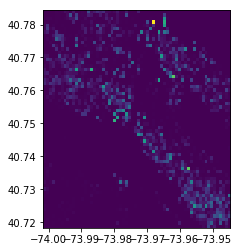

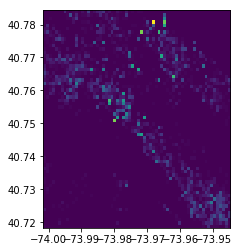

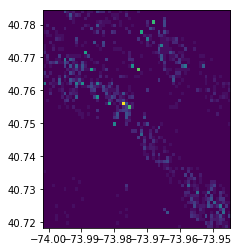

In [45]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 
constant_offset = 0.01#0.05
x_min, x_max = loc_df.describe()['longitude']['25%']-constant_offset, loc_df.describe()['longitude']['75%']+constant_offset
y_min, y_max = loc_df.describe()['latitude']['25%']-constant_offset, loc_df.describe()['latitude']['75%']+constant_offset


loc_df2 = pd.DataFrame({'longitude':df_raw['longitude'],'latitude':df_raw['latitude'],'interest_level':df_raw['interest_level']}) 
loc_df2 = loc_df2[(loc_df2['latitude'] >= y_min) & (loc_df2['latitude'] <= y_max) & 
                 (loc_df2['longitude'] >= x_min) & (loc_df2['longitude'] <= x_max) ]
print(loc_df2.head())
# Create heatmap
bin_size = 64
heatmap, xedges, yedges = np.histogram2d(loc_df2['longitude'][loc_df2['interest_level'] == "low"], loc_df2['latitude'][loc_df2['interest_level'] == "low"] , 
                                          bins=(bin_size,bin_size))
heatmap2, xedges, yedges = np.histogram2d(loc_df2['longitude'][loc_df2['interest_level'] == "medium"], loc_df2['latitude'][loc_df2['interest_level'] == "medium"] , 
                                         bins=(bin_size,bin_size))
heatmap3, xedges, yedges = np.histogram2d(loc_df2['longitude'][loc_df2['interest_level'] == "high"],loc_df2['latitude'][loc_df2['interest_level'] == "high"] , 
                                          bins=(bin_size,bin_size))

extent = [x_min, x_max, y_min, y_max]
 
# Plot heatmap
plt.figure(1)
plt.clf()
plt.imshow(heatmap, extent=extent)
plt.figure(2)
plt.imshow(heatmap2, extent=extent)
plt.figure(3)
plt.imshow(heatmap3, extent=extent)
plt.show()

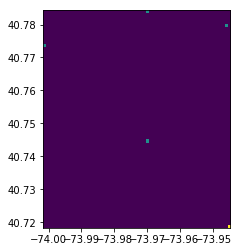

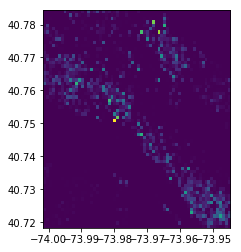

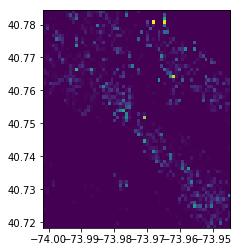

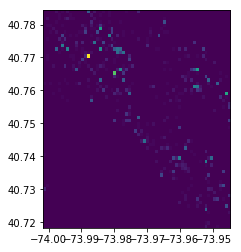

In [120]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 
constant_offset = 0.01#0.05
x_min, x_max = loc_df.describe()['longitude']['25%']-constant_offset, loc_df.describe()['longitude']['75%']+constant_offset
y_min, y_max = loc_df.describe()['latitude']['25%']-constant_offset, loc_df.describe()['latitude']['75%']+constant_offset

# Create data
loc_df3 = pd.DataFrame({'longitude':df_raw['longitude'],'latitude':df_raw['latitude'],'per_bedroom':df_raw['price_per_bed']}) 
loc_df3 = loc_df3[(loc_df3['latitude'] >= y_min) & (loc_df3['latitude'] <= y_max) & 
                 (loc_df3['longitude'] >= x_min) & (loc_df3['longitude'] <= x_max) ]


# Create heatmap
bin_size = 64
per_bedroom_median = loc_df3['per_bedroom'].median()
per_bedroom_min = per_bedroom_median - loc_df3.describe()['per_bedroom']['25%']
per_bedroom_max = per_bedroom_median + loc_df3.describe()['per_bedroom']['25%']
heatmap, xedges, yedges = np.histogram2d(
    loc_df3['longitude'][loc_df3['per_bedroom'] <= per_bedroom_min], 
    loc_df3['latitude'][loc_df3['per_bedroom'] <= per_bedroom_min ] , 
                                         bins=(bin_size,bin_size))
heatmap2, xedges, yedges = np.histogram2d(
    loc_df3['longitude'][(loc_df3['per_bedroom'] >= per_bedroom_min) & (loc_df3['per_bedroom'] <= per_bedroom_median)],
    loc_df3['latitude'][(loc_df3['per_bedroom'] >= per_bedroom_min) & (loc_df3['per_bedroom'] <= per_bedroom_median)] ,
     bins=(bin_size,bin_size))
heatmap3, xedges, yedges = np.histogram2d(
    loc_df3['longitude'][(loc_df3['per_bedroom'] >= per_bedroom_median) & (loc_df3['per_bedroom'] <= per_bedroom_max)],
    loc_df3['latitude'][(loc_df3['per_bedroom'] >= per_bedroom_median) & (loc_df3['per_bedroom'] <= per_bedroom_max)] ,
     bins=(bin_size,bin_size))
heatmap4, xedges, yedges = np.histogram2d(
    loc_df3['longitude'][loc_df3['per_bedroom'] >= per_bedroom_max],
    loc_df3['latitude'][loc_df3['per_bedroom'] >= per_bedroom_max] , 
                                          bins=(bin_size,bin_size))

extent = [x_min, x_max, y_min, y_max]
 
# Plot heatmap
plt.figure(1)
plt.clf()
plt.imshow(heatmap, extent=extent)
plt.figure(2)
plt.imshow(heatmap2, extent=extent)
plt.figure(3)
plt.imshow(heatmap3, extent=extent)
plt.figure(4)
plt.imshow(heatmap4, extent=extent)
plt.show()

Low per bedroom apartments on the outskirts. High per bedroom apartments have fewer high density areas. 25% to 50% quantile and 50% to 75% quantiles have more specific densities and some overlap.

Creating two new features: latitude_modified and longitude_modified. Replaces obviously false extreme location outliers with more reasonable extremes.

In [113]:
df_temp = pd.DataFrame( {'longitude': df_raw['longitude'],'latitude':df_raw['latitude']})
latitude_modified = pd.Series(df_temp['latitude'])
longitude_modified = pd.Series(df_temp['longitude'])

constant_offset = 0.25
x_min, x_max = df_raw.describe()['longitude']['25%']-constant_offset, df_raw.describe()['longitude']['75%']+constant_offset
y_min, y_max = df_raw.describe()['latitude']['25%']-constant_offset, df_raw.describe()['latitude']['75%']+constant_offset

#print(x_min,x_max,y_min,y_max)
latitude_modified[latitude_modified > y_max] = y_max
latitude_modified[latitude_modified < y_min] = y_min
longitude_modified[longitude_modified > x_max] = x_max
longitude_modified[longitude_modified < x_min] = x_min
df_raw['latitude_modified'] = pd.Series(latitude_modified,index=df_raw.index)
df_raw['longitude_modified'] = pd.Series(longitude_modified,index=df_raw.index)
#df_raw.describe()

In [116]:
#df_raw.columns.values
#df_raw.head()
#df_raw.describe()
#df_raw['features_count'].describe()
#df_raw.to_pickle("train_checkpoint_2")

Prepare the test data set.

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
import pickle

with open('renthop_test.json') as json_data:
    test_data_json = json.load(json_data)
    
df_test_data = pd.DataFrame.from_records(test_data_json)
df_test_data["created"] = pd.to_datetime(df_test_data["created"])

df_2 = pd.DataFrame( {'bathrooms': df_test_data['bathrooms'],'bedrooms':df_test_data['bedrooms'],
                            'price':df_test_data['price']})

mod_bed = pd.Series(df_2['bedrooms'])
mod_bed[mod_bed == 0] = studio_bedroom
df_test_data['bedrooms_modified'] = pd.Series(mod_bed,index=df_test_data.index)

price_modified = pd.Series(df_2['price'])
price_modified[price_modified >= 50000] = 50000
per_bed = pd.Series(price_modified/mod_bed)
df_test_data['price_modified'] = pd.Series(price_modified,index=df_test_data.index)
df_test_data['price_per_bed'] = pd.Series(per_bed,index=df_test_data.index)

#df_test_data.describe()
#df_test_data.to_pickle("test_checkpoint_1")

created_hour_list = []
created_dow_list = [] #0 is monday, 6 is sunday
created_day_list = []
created_month_list = []
for x in df_test_data['created']:
    x_hour = x.hour
    x_minute = x.minute
    x_dow = x.dayofweek
    x_day = x.day
    x_month = x.month
    
    if x_minute > 30:
        x_hour += 1
        if x_hour > 23:
            x_hour = 0
    
    if x_day > 29: #only 1 month had a 31st day
        x_day = 30
        
    created_hour_list.append(x_hour)
    created_dow_list.append(x_dow)
    created_day_list.append(x_day)
    created_month_list.append(x_month)

df_test_data['created_hour'] = pd.Series(created_hour_list, index=df_test_data.index)
df_test_data['created_dow'] = pd.Series(created_dow_list, index=df_test_data.index)
df_test_data['created_day'] = pd.Series(created_day_list, index=df_test_data.index)
df_test_data['created_month'] = pd.Series(created_month_list, index=df_test_data.index)


df_test_data['description_length'] = pd.Series(df_test_data['description'].str.len(), index=df_test_data.index)


df_3 = pd.DataFrame( {'listing_id': df_test_data['listing_id'],'features':df_test_data['features']})
feature_list = []
feature_list_count = []
for x in df_3['features']:
    feature_list_count.append(len(x))
    for y in x:
        if y not in feature_list:
            feature_list.append(y)

df_test_data['features_count'] = pd.Series(feature_list_count, index=df_test_data.index)


apt_feature_length = len(df_test_data['features'])
apt_feature_array = np.zeros([apt_feature_length, 10])
#print(apt_feature_array.shape)
apt_feature_search_string = [["elevator"],["cats"],["hardwood"],["dogs"],["doorman"],["dishwasher"],
                             ["no fee"],["laundry"],["fitness","gym"],["pre-war","prewar","pre war"]]
z_break = 0
for i in range(apt_feature_length):
    feature_list = df_test_data['features'].iloc[i]
    for feature in feature_list:
        temp_feature = feature.lower()
        #print(i, temp_feature)
        for j in range(10):#search_category in apt_feature_search_string:
            search_category = apt_feature_search_string[j]
            for search_string in search_category:
                if search_string in temp_feature:
                    apt_feature_array[i,j] = 1
                    break
                    
z_string = "apt_feature_"
for i in range(10):
    temp_string = z_string + apt_feature_search_string[i][0]
    #print(temp_string)
    df_test_data[temp_string] = pd.Series(apt_feature_array[:,i],index=df_test_data.index)
    
#df_test_data.describe()
#df_test_data.to_pickle("test_checkpoint_12")

df_test_data = df_test_data.join(df_manager.set_index('manager_id'),on='manager_id')
df_test_data = df_test_data.join(df_building.set_index('building_id'),on='building_id')

#some managers/buildings in test set don't show up in train set
df_test_data['manager_count'].fillna(0, inplace=True)
df_test_data['manager_low'].fillna(0, inplace=True)
df_test_data['manager_medium'].fillna(0, inplace=True)
df_test_data['manager_high'].fillna(0, inplace=True)
df_test_data['building_count'].fillna(0, inplace=True)
df_test_data['building_low'].fillna(0, inplace=True)
df_test_data['building_medium'].fillna(0, inplace=True)
df_test_data['building_high'].fillna(0, inplace=True)

image_dict = pickle.load( open( "image_count_dict.p", "rb" ) )

image_count = []
for x in df_test_data['listing_id']:
    y = str(x)
    if y in image_dict:
        image_count.append(image_dict[y])
    else:
        image_count.append(0)
    
df_test_data['image_count'] = pd.Series(image_count,index=df_test_data.index)


df_temp = pd.DataFrame( {'longitude': df_test_data['longitude'],'latitude':df_test_data['latitude']})
latitude_modified = pd.Series(df_temp['latitude'])
longitude_modified = pd.Series(df_temp['longitude'])

constant_offset = 0.25
x_min, x_max = df_raw.describe()['longitude']['25%']-constant_offset, df_raw.describe()['longitude']['75%']+constant_offset
y_min, y_max = df_raw.describe()['latitude']['25%']-constant_offset, df_raw.describe()['latitude']['75%']+constant_offset

#print(x_min,x_max,y_min,y_max)
latitude_modified[latitude_modified > y_max] = y_max
latitude_modified[latitude_modified < y_min] = y_min
longitude_modified[longitude_modified > x_max] = x_max
longitude_modified[longitude_modified < x_min] = x_min
df_test_data['latitude_modified'] = pd.Series(latitude_modified,index=df_test_data.index)
df_test_data['longitude_modified'] = pd.Series(longitude_modified,index=df_test_data.index)

df_test_data.to_pickle("test_checkpoint_2")

In [277]:
print(df_test_data.isnull().values.any())
'''print(len(df_test_data.columns.values))
print(df_test_data.columns.values)
print(df_test_data.head())
print(df_test_data.describe())'''

False


'print(len(df_test_data.columns.values))\nprint(df_test_data.columns.values)\nprint(df_test_data.head())\nprint(df_test_data.describe())'

## Checkpoint
Data can be loaded from pickle file train_checkpoint_2

## 2.0 Model Building

After some consideration, I chose the following models to train the data on:
* Random Forest: From what I've learned, trees are typically a good classifier. After looking at the data, I felt that trees would be good at making inferences from many of the marginal and unusual samples. Can also use 'feature_importances' to see the relative effect of each column 
* Logistic Regression: Simple to implement, outputs probabilities.
* Naive Bayes: Not a good solution for this type of problem but simple enough to train and often effective.
* Adaboost: For many of the reasons I chose Random Forest, I thought a boosting algorithm with some of the similar properties could prove useful.
* SGD Classifier 
* XGBoost: Powerful boosting that is used on a large amount of Kaggle entries.
* Voting Classifier: As I altered most of the inputs and modified the feature space, I am hopeful that by combining some of my models I can leverage their individual strengths to produce better predictions

Load the data, separate the label data, and encode it. Drop unused columns.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
#le = preprocessing.LabelEncoder()

df_pre_train = pd.read_pickle("train_checkpoint_2")
df_kaggle_test = pd.read_pickle("test_checkpoint_2")
#print(len(df_pre_train.columns.values),len(df_kaggle_test.columns.values))

temp = lb.fit_transform(df_pre_train['interest_level'])

df_pre_train_label_matrix = pd.DataFrame({'interest0_low':temp[:,1],'interest1_medium':temp[:,2],'interest2_high':temp[:,0]})
df_pre_train_label_vector = df_pre_train['interest_level'].map({'low':0,'medium':1,'high':2})

drop_columns = ['bedrooms','building_id','created','description','display_address','features','interest_level','latitude',
                'listing_id','longitude','manager_id','photos','price',
               'street_address']
df_pre_train.drop(drop_columns, axis = 1, inplace = True)

drop_columns_test = ['bedrooms','building_id','created','description','display_address','features','latitude',
                'listing_id','longitude','manager_id','photos','price',
               'street_address']
df_kaggle_test.drop(drop_columns_test, axis = 1, inplace = True)


In [27]:
df_pre_train.columns.values

array(['bathrooms', 'bedrooms_modified', 'price_modified', 'price_per_bed',
       'created_hour', 'created_dow', 'created_day', 'created_month',
       'description_length', 'features_count', 'apt_feature_elevator',
       'apt_feature_cats', 'apt_feature_hardwood', 'apt_feature_dogs',
       'apt_feature_doorman', 'apt_feature_dishwasher',
       'apt_feature_no fee', 'apt_feature_laundry', 'apt_feature_fitness',
       'apt_feature_pre-war', 'manager_count', 'manager_low',
       'manager_medium', 'manager_high', 'building_count', 'building_low',
       'building_medium', 'building_high', 'image_count',
       'latitude_modified', 'longitude_modified'], dtype=object)

Standardize features

In [28]:
'''standardize_columns = ['bathrooms', 'bedrooms_modified',
       'price_modified', 'price_per_bed', 'created_hour', 'created_dow',
       'created_day', 'created_month', 'description_length',
       'features_count', 'manager_low', 'manager_medium', 'manager_high',
       'building_count', 'building_low', 'building_medium',
       'building_high', 'image_count', 'latitude_modified',
       'longitude_modified']'''

from sklearn.preprocessing import StandardScaler

standardize_columns = ['price_modified', 'price_per_bed','latitude_modified',
       'longitude_modified']

X_scaler = StandardScaler()
df_pre_train[standardize_columns] = X_scaler.fit_transform(df_pre_train[standardize_columns])

df_kaggle_test[standardize_columns] = X_scaler.transform(df_kaggle_test[standardize_columns])

In [29]:
df_pre_train.head()

,bathrooms,bedrooms_modified,price_modified,price_per_bed,created_hour,created_dow,created_day,created_month,description_length,features_count,...,manager_low,manager_medium,manager_high,building_count,building_low,building_medium,building_high,image_count,latitude_modified,longitude_modified
10,1.5,3.0,-0.282271,-1.121356,8,4,24,6,588,0,...,67,22,0,2,2,0,0,5,-0.906438,0.971285
10000,1.0,2.0,0.756344,0.218660,12,6,12,6,8,5,...,84,1,0,23,21,2,0,11,1.085420,0.184457
100004,1.0,1.0,-0.345473,0.309541,3,6,17,4,691,4,...,77,49,7,57,22,26,9,8,-0.302920,-0.956769
100007,1.0,1.0,-0.166401,0.638261,2,0,18,4,492,2,...,153,24,13,98,88,9,1,3,0.072106,0.151944
100013,1.0,4.0,-0.134801,-1.247043,2,3,28,4,479,1,...,14,0,0,8285,7587,503,195,3,1.815603,0.750193


Creating 3 sets: training set, validation set, and test set. Some of the models I use are improved by [probability calibration](http://scikit-learn.org/stable/modules/calibration.html) and a validation set helps with the creation of those models.

In [30]:
from sklearn.model_selection import train_test_split

X_train2, X_val2, y_train2, y_val2 = train_test_split(df_pre_train, df_pre_train_label_vector, test_size=0.3, random_state=0)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_val2, y_val2, test_size=0.5, random_state=0)

print (len(X_train2),len(X_val2),len(X_test2))

34546 7403 7403


### Scoring Functions
I create a custom scorer so that GridSearchCV can evaluate the models after probability calibration. Other than Logistic Regression, the other models I choose benefit from [probability calibration](http://scikit-learn.org/stable/modules/calibration.html#calibration).

In [31]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import log_loss, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

#cross validation sets used by GridSearch
rs = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 0)
cv_sets = rs.get_n_splits(X_train2)

#custom scorer used in GridSearchCV.
#Training data is used in cross-validation sets by GridSearch to train the initial model.
#heldout part of the cv set is used as X,y in the function.
#outside validation set used to fit the CalibratedClassifierCV

def custom_ccv_scorer(estimator,X,y):
    ccv = CalibratedClassifierCV(estimator,method="isotonic", cv="prefit")
    ccv.fit(X_val2,y_val2) #fit to overall validation set
    ccv_predictions = ccv.predict_proba(X)
    ccv_score = log_loss(y,ccv_predictions)
    #Take the negative as GridSearchCV optimizes by highest value while smaller positive values are better for log loss.
    return -ccv_score
    
#log_loss argument works by default, don't need to implement a custom log_loss scoring function
#scoring_fnc = make_scorer(log_loss,greater_is_better=False, needs_proba=True)

def describe_grid_model(grid_model):
    best_model = grid_model.best_estimator_
    predictions = best_model.predict_proba(X_test2)
    score = log_loss(y_test2,predictions)
    ccv = CalibratedClassifierCV(best_model,method="isotonic", cv="prefit")
    ccv.fit(X_val2,y_val2) #fit to overall validation set
    ccv_predictions = ccv.predict_proba(X_test2)
    ccv_score = log_loss(y_test2,ccv_predictions)
    print('CCV Score, Base Model Score:', ccv_score,',',score )
    df_grid = pd.DataFrame(grid_model.cv_results_)
    print(df_grid['params'])
    print(df_grid['mean_test_score'])

### Benchmark Score
Test the benchmark score on the overall data. I also submitted a benchmark sample to Kaggle and received a score of 0.79075. Scores for the benchmark model for the overall training set, the test subset of the training set, and the Kaggle score on the withheld test set are all roughly 0.79.

In [32]:
from sklearn.metrics import log_loss

benchmark_dict = {'high': 0.07778813421948452,
 'low': 0.6946830928837737,
 'medium': 0.22752877289674178}
benchmark_array = [round(0.6946830928837737,5),round(0.22752877289674178,5),round(0.07778813421948452,5)]
#benchmark_output = 
length = len(df_pre_train)
benchmark_output = np.array([np.repeat(benchmark_dict['low'],length),np.repeat(benchmark_dict['medium'],length),
                            np.repeat(benchmark_dict['high'],length)])
benchmark_output = benchmark_output.T

benchmark_score = log_loss(df_pre_train_label_vector, benchmark_output)

#used for some class_weight features
cw_dict = {0:round(0.6946830928837737,5),1:round(0.22752877289674178,5),2:round(0.07778813421948452,5)}

print('Benchmark Log Loss Score:',benchmark_score)

length = len(y_test2)
benchmark_test = np.array([np.repeat(benchmark_dict['low'],length),np.repeat(benchmark_dict['medium'],length),
                            np.repeat(benchmark_dict['high'],length)])
benchmark_test = benchmark_test.T
benchmark_test_data_score = log_loss(y_test2, benchmark_test)
print('Test Data Log Loss Score:',benchmark_test_data_score)

Benchmark Log Loss Score: 0.788576911432
Test Data Log Loss Score: 0.785216840872


In [34]:
from sklearn.metrics import log_loss

benchmark_dict = {'high': 0.07778813421948452,
 'low': 0.6946830928837737,
 'medium': 0.22752877289674178}

length = len(df_kaggle_test)
#print(length)
benchmark_2 = np.array([np.repeat(benchmark_dict['low'],length),np.repeat(benchmark_dict['medium'],length),
                            np.repeat(benchmark_dict['high'],length)])
benchmark_2 = benchmark_2.T

df_bench_out = pd.DataFrame({"alisting_id":df_kaggle_test_pickle['listing_id'],"bhigh":benchmark_2[:,2],
                       "cmedium":benchmark_2[:,1],"dlow":benchmark_2[:,0]})
df_bench_out = df_bench_out.rename(columns={ 'alisting_id':'listing_id', 'bhigh':'high','cmedium':'medium'
                          ,'dlow':'low'})

#benchmark_score = log_loss(df_pre_train_label_vector, benchmark_output)  
df_bench_out.head()

df_bench_out.to_csv("renthop_bench_submission.csv",index=False)

print('Submitted benchmark to Kaggle for testing and received a score of 0.79075')

## 2.1 Logistic Regression
Logistic Regression does not need probability calibration. Thus uses GridSearchCV with "neg_log_loss" and not the custom scorer. I tried GridSearch with some different parameter configurations but the model failed to converge despite very high values for max_iter. Despite the data have different class distributions, class_weight of 'None' outperformed 'balanced' in every configuration.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#gs_parameters = {'solver':('sag'),'C':[,1,.3,1.0,1.5],'max_iter':[10],'class_weight':('balanced',None)}
#gs_parameters = {'C':[.1,.3,1.0,1.5],'max_iter':[100],'class_weight':('balanced',None)}
gs_parameters = {'max_iter':[100,500,1000,2000,5000],'class_weight':('balanced',None)}
#options: None for class_weight (getting beter results but not sure why), just sag as a solver
#'solver':('sag','lbfgs','newton-cg')
#'C':[.1,.3,1.0,1.5]
#tried some different C values, not much of a difference

#lr_model = LogisticRegression(random_state=0,solver='sag',multi_class='multinomial',class_weight='balanced',max_iter=1000,n_jobs=-1)
lr_model = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial',class_weight=None,max_iter=500,n_jobs=-1)
#500 iter lbfgs 0.623466269
#gs_lr_model = GridSearchCV(lr_model, param_grid=gs_parameters,scoring="neg_log_loss",cv=cv_sets)
#gs_lr_model.fit(X_train2,y_train2)

lr_model.fit(X_train2, y_train2)
lr_predictions = lr_model.predict_proba(X_test2)
lr_score = log_loss(y_test2,lr_predictions)
print(lr_score)


0.623466269452


In [ ]:
#describe_grid_model(gs_lr_model)


In [122]:
with open('renthop_lr.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

## 2.2 Random Forest Classifier
I fit the Random Forest by doing [probability calibration](http://scikit-learn.org/stable/modules/calibration.html#calibration) due to how Random Forests can behave at certain probability ranges. I tested some different parameters like n_estimators, criterion, and min_sample_leaf before deciding on the model below.

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 0,n_estimators = 50,oob_score = True,class_weight='balanced_subsample',
                                 criterion='gini', min_samples_leaf=2) #'entropy','gini'

#gs_parameters = {'n_estimators':[100,200,500,1000],'criterion':('gini','entropy')}
#gs_parameters = {'n_estimators':[100,200,500,1000],'criterion':('gini','entropy')}
gs_parameters = {'n_estimators':[100,200,500,1000]} #,'criterion':('gini','entropy')

# gs_rf_model = GridSearchCV(rf_model, param_grid=gs_parameters,scoring="neg_log_loss",cv=cv_sets)
gs_rf_model = GridSearchCV(rf_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_rf_model.fit(X_train2,y_train2)

# rf_model.fit(X_train2,y_train2)
# rf_predictions = rf_model.predict_proba(X_test2)
# rf_score = log_loss(y_test2,rf_predictions)
# rf_score_ccv = custom_ccv_scorer(rf_model,X_test2,y_test2)
# print(rf_score,rf_score_ccv)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x00000000134D1EA0>,
       verbose=0)

In [84]:
describe_grid_model(gs_rf_model)
#print(gs_rf_model.cv_results_)

CCV Score, Base Model Score: 0.44983942647 , 0.464199845765
0     {'n_estimators': 100}
1     {'n_estimators': 200}
2     {'n_estimators': 500}
3    {'n_estimators': 1000}
Name: params, dtype: object
0   -0.464240
1   -0.463038
2   -0.459915
3   -0.455477
Name: mean_test_score, dtype: float64


The importance of the various features for the random forest model.

In [264]:
for x,y in zip(gs_rf_model.best_estimator_.feature_importances_,X_train2.columns.values):
    print(y,round(x,3))

bathrooms 0.006
bedrooms_modified 0.014
price_modified 0.078
price_per_bed 0.084
created_hour 0.031
created_dow 0.022
created_day 0.036
created_month 0.013
description_length 0.046
features_count 0.027
apt_feature_elevator 0.005
apt_feature_cats 0.005
apt_feature_hardwood 0.006
apt_feature_dogs 0.005
apt_feature_doorman 0.004
apt_feature_dishwasher 0.006
apt_feature_no fee 0.011
apt_feature_laundry 0.006
apt_feature_fitness 0.004
apt_feature_pre-war 0.005
manager_count 0.041
manager_low 0.07
manager_medium 0.07
manager_high 0.077
building_count 0.038
building_low 0.061
building_medium 0.058
building_high 0.05
image_count 0.03
latitude_modified 0.044
longitude_modified 0.046


In [121]:
with open('renthop_rf.pkl', 'wb') as f:
    pickle.dump(gs_rf_model, f)

## 2.3 Naive Bayes
From what I read on sklearn, Naive Bayes can be good as classifier but is known to be a bad estimator. Even though it is unlikely to be the best model, the model is so quick to train I did so anyway with the hope that it can be useful in a voting classifier situation.


In [127]:
from sklearn.naive_bayes import GaussianNB

bnb_model = GaussianNB(priors=benchmark_array)
bnb_model.fit(X_train2,y_train2)
bnb_predictions = bnb_model.predict_proba(X_test2)
bnb_score = log_loss(y_test2,bnb_predictions,labels=[0,1,2])

#fit the CCV model for later use
bnb_ccv = CalibratedClassifierCV(bnb_model, method="isotonic", cv="prefit") #'isotonic' or 'sigmoid'
bnb_ccv.fit(X_val2,y_val2)
bnb_ccv_predictions = bnb_ccv.predict_proba(X_test2)
bnb_ccv_score = log_loss(y_test2,bnb_ccv_predictions)

print(bnb_score, bnb_ccv_score)

2.05159284343 0.708279179393


In [120]:
with open('renthop_nb.pkl', 'wb') as f:
    pickle.dump(bnb_ccv, f)

## 2.3 Stochastic Gradient Descent
Modified huber and log are the only loss arguments that work with predicting probabilities. I tried handtuning some of the other parameters before settling on the ones below.

In [39]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='modified_huber',penalty='l2',n_iter=300,class_weight='balanced',learning_rate='optimal')
#sgd_model = SGDClassifier(loss='modified_huber',penalty='l2',n_iter=100,class_weight='balanced',learning_rate='optimal')
#penalty : str, ‘none’, ‘l2’, ‘l1’, or ‘elasticnet’

sgd_model.fit(X_train2,y_train2)
sgd_predictions = sgd_model.predict_proba(X_test2)
print(sum(np.isnan(sgd_predictions)))
sgd_score = log_loss(y_test2,sgd_predictions)

sgd_ccv = CalibratedClassifierCV(sgd_model, method="isotonic", cv="prefit")
sgd_ccv.fit(X_val2,y_val2)
sgd_ccv_predictions = sgd_ccv.predict_proba(X_test2)
sgd_ccv_score = log_loss(y_test2,sgd_ccv_predictions)

print(sgd_score,sgd_ccv_score)

[0 0 0]
6.44114507959 0.681982141406


In [119]:
with open('renthop_sgd.pkl', 'wb') as f:
    pickle.dump(sgd_ccv, f)

## 2.4 K-Nearest Neighbors

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_model = KNeighborsClassifier(n_neighbors=5,weights='uniform',algorithm='auto')

#gs_parameters = {'n_neighbors':[5,10],'weights':('uniform','distance'),'p':[1,2]}
gs_parameters = {'n_neighbors':[5,10,15,20]}
gs_knn_model = GridSearchCV(knn_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_knn_model.fit(X_train2,y_train2)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x00000000134D1EA0>,
       verbose=0)

In [83]:
describe_grid_model(gs_knn_model)

CCV Score, Base Model Score: 0.683435326532 , 1.00908464346
0     {'n_neighbors': 5}
1    {'n_neighbors': 10}
2    {'n_neighbors': 15}
3    {'n_neighbors': 20}
Name: params, dtype: object
0   -0.723601
1   -0.707703
2   -0.702463
3   -0.697843
Name: mean_test_score, dtype: float64


In [118]:
with open('renthop_knn.pkl', 'wb') as f:
    pickle.dump(gs_knn_model, f)

## 2.5 Adaboost

In [93]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_rand

ada_model = AdaBoostClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    n_estimators=100,
    learning_rate=1)

'''search_parameters = {'n_estimators':sp_randint(30,301),
                    'learning_rate':sp_randint(0,2)}'''

search_parameters = {'n_estimators':sp_randint(300,1001),
                    'learning_rate':sp_rand(.001,1.0)}

rs_ada_model = RandomizedSearchCV(ada_model,param_distributions=search_parameters,
                                  scoring=custom_ccv_scorer,cv=cv_sets,n_iter=20)
rs_ada_model.fit(X_train2,y_train2)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1, n_estimators=100, random_state=None),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C0EE630>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C0EE5F8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=<function custom_ccv_scorer at 0x00000000134D1EA0>,
          verbose=0)

In [94]:
describe_grid_model(rs_ada_model)

CCV Score, Base Model Score: 0.571028009793 , 6.80698024587
0     {'learning_rate': 0.256575792242, 'n_estimator...
1     {'learning_rate': 0.390324400716, 'n_estimator...
2     {'learning_rate': 0.363187239991, 'n_estimator...
3     {'learning_rate': 0.526237999985, 'n_estimator...
4     {'learning_rate': 0.0751293632145, 'n_estimato...
5     {'learning_rate': 0.516407308051, 'n_estimator...
6     {'learning_rate': 0.380997049204, 'n_estimator...
7     {'learning_rate': 0.481041633657, 'n_estimator...
8     {'learning_rate': 0.653737793866, 'n_estimator...
9     {'learning_rate': 0.0746083497833, 'n_estimato...
10    {'learning_rate': 0.937062793119, 'n_estimator...
11    {'learning_rate': 0.375701038393, 'n_estimator...
12    {'learning_rate': 0.824547959806, 'n_estimator...
13    {'learning_rate': 0.521307485454, 'n_estimator...
14    {'learning_rate': 0.142927095424, 'n_estimator...
15    {'learning_rate': 0.700549787568, 'n_estimator...
16    {'learning_rate': 0.106887650733, 'n_e

In [96]:
print(rs_ada_model.cv_results_['params'])
print(rs_ada_model.best_estimator_)

({'learning_rate': 0.25657579224205407, 'n_estimators': 493}, {'learning_rate': 0.39032440071569308, 'n_estimators': 919}, {'learning_rate': 0.36318723999090974, 'n_estimators': 797}, {'learning_rate': 0.52623799998468779, 'n_estimators': 399}, {'learning_rate': 0.075129363214500589, 'n_estimators': 754}, {'learning_rate': 0.51640730805095747, 'n_estimators': 854}, {'learning_rate': 0.38099704920395472, 'n_estimators': 684}, {'learning_rate': 0.48104163365710395, 'n_estimators': 754}, {'learning_rate': 0.65373779386578224, 'n_estimators': 687}, {'learning_rate': 0.074608349783252148, 'n_estimators': 388}, {'learning_rate': 0.9370627931185338, 'n_estimators': 613}, {'learning_rate': 0.37570103839341984, 'n_estimators': 571}, {'learning_rate': 0.82454795980633244, 'n_estimators': 885}, {'learning_rate': 0.52130748545354844, 'n_estimators': 429}, {'learning_rate': 0.14292709542375748, 'n_estimators': 444}, {'learning_rate': 0.70054978756757424, 'n_estimators': 451}, {'learning_rate': 0.10

Most important features for the Adaboost model.

In [97]:
for x,y in zip(rs_ada_model.best_estimator_.feature_importances_,X_train2.columns.values):
    print(y,round(x,3))

bathrooms 0.002
bedrooms_modified 0.005
price_modified 0.087
price_per_bed 0.082
created_hour 0.02
created_dow 0.015
created_day 0.028
created_month 0.006
description_length 0.043
features_count 0.019
apt_feature_elevator 0.004
apt_feature_cats 0.002
apt_feature_hardwood 0.002
apt_feature_dogs 0.002
apt_feature_doorman 0.002
apt_feature_dishwasher 0.001
apt_feature_no fee 0.006
apt_feature_laundry 0.004
apt_feature_fitness 0.001
apt_feature_pre-war 0.004
manager_count 0.028
manager_low 0.105
manager_medium 0.105
manager_high 0.181
building_count 0.013
building_low 0.03
building_medium 0.055
building_high 0.05
image_count 0.019
latitude_modified 0.042
longitude_modified 0.037


In [117]:
with open('renthop_ada.pkl', 'wb') as f:
    pickle.dump(rs_ada_model, f)

## 2.6 Gradient Boosting
I installed and implemented the XGBoost package. Some of the code for this part is from an [example I found online](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In [106]:
import xgboost as xgb

gb_model = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.05,
                             objective='binary:logistic')
#objective multi:softprob
#"objective" = "multi:softprob",    # multiclass classification 
#              "num_class" = 3,    # number of classes 

gs_parameters = {   
    'max_depth':range(3,10,2),
    'n_estimators':range(100,500,50),
    'learning_rate':[0.05,0.10,0.20,0.30]
}
gs_gb_model = GridSearchCV(gb_model, param_grid=gs_parameters,scoring="neg_log_loss",cv=cv_sets)
gs_gb_model.fit(X_train2,y_train2) #eval_metric="mlogloss "

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(100, 500, 50), 'learning_rate': [0.05, 0.1, 0.2, 0.3], 'max_depth': range(3, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [108]:
#describe_grid_model(gs_gb_model)
predictions = gs_gb_model.best_estimator_.predict_proba(X_test2)
score = log_loss(y_test2,predictions)
print(score)

0.246955397986


While the log loss of the xgboost model was on the test data was incredibly low, this was due to the model overfitting. When I submitted this model on Kaggle, the model performed about as well as the benchmark set. <br/>
Feature importance of xgboost model.

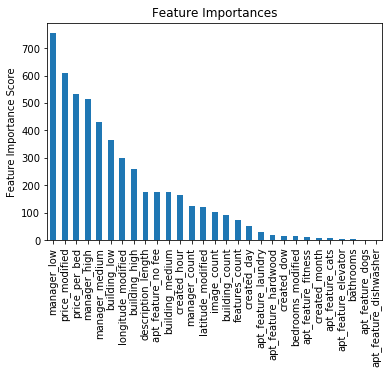

In [123]:
feat_imp = pd.Series(gs_gb_model.best_estimator_.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()


In [111]:
import pickle
# now you can save it to a file
with open('renthop_xgb.pkl', 'wb') as f:
    pickle.dump(gs_gb_model, f)

## 2.7 Voting Classifier

In [131]:
from sklearn.ensemble import VotingClassifier

#vc_model = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])
#rf: gs_rf_model.best_estimator_
#lr: lr_model
#knn: gs_knn_model.best_estimator_
#nb: bnb_model
#sgd: sgd_model
#gb: gs_gb_model.best_estimator_
#ada: rs_ada_model.best_estimator_

vc_model = VotingClassifier(estimators=[('rf', gs_rf_model.best_estimator_), ('lr', lr_model), 
                                        ('knn', gs_knn_model.best_estimator_), ('gb', gs_gb_model.best_estimator_), 
                                        ('nb', bnb_model), ('sgd', sgd_model), ('ada', rs_ada_model.best_estimator_)], voting='soft')
#vc_model = VotingClassifier(estimators=[('nb', bnb_model), ('lr', lr_model)], voting='soft')

vc_model.fit(X_train2,y_train2)
vc_predictions = vc_model.predict_proba(X_test2)
vc_score = log_loss(y_test2,vc_predictions)
print(vc_score)

0.48769409224


The voting classifier model received a 0.65518 on Kaggle. Better than the other models I submitted (xgboost, the benchmark, and random forest) but still not as well as the log loss on the test data indicated.

In [132]:
with open('renthop_vc.pkl', 'wb') as f:
    pickle.dump(vc_model, f)

## 3.0 Feature Selection
From what I have read, typically feature selection is done prior to model fitting or in a conjunction with a pipeline. However I decided to do it after fitting a model for a couple of reasons. First, I thought that some bad features that are mostly the same (like almost all bathrooms being equal to 1) would still have some predictive value for the bad inputs. Second, I created many new input features and wanted to get a sense of how they contributed to various models prior to me creating them and then immediately cutting them.

SelectFromModel feature selection: takes an already fitted model and prunes down the features deemed unnecessary.

In [ ]:
#convenience function to see which features are kept or dropped
def print_selected_features(column_names,clf):
    features_bool = clf.get_support()
    #print("Kept Features",column_names[features_bool])
    print( "Kept Features", column_names * features_bool)
    z = [not i for i in features_bool]
    print( "Dropped Features", column_names * z)

In [217]:
from sklearn.feature_selection import SelectFromModel

sfm_rf_model = SelectFromModel(gs_rf_model.best_estimator_, prefit=True)
#X_transform = sfm_model.transform(X_train2)
#print_selected_features(X_train2.columns.values,sfm_rf_model)

sfm_xgb_model = SelectFromModel(gs_gb_model.best_estimator_, prefit=True)
#X_transform = sfm_model.transform(X_train2)
#print_selected_features(X_train2.columns.values,sfm_xgb_model)

sfm_ada_model = SelectFromModel(rs_ada_model.best_estimator_, prefit=True)
#X_transform = sfm_model.transform(X_train2)
#print_selected_features(X_train2.columns.values,sfm_ada_model)

sfm_lr_model = SelectFromModel(lr_model, prefit=True)
#X_transform = sfm_model.transform(X_train2)
#print_selected_features(X_train2.columns.values,sfm_lr_model)

sfm_sgd_model = SelectFromModel(sgd_model, prefit=True)
#X_transform = sfm_model.transform(X_train2)
#print_selected_features(X_train2.columns.values,sfm_sgd_model)

In [214]:
df_sfm = pd.DataFrame({'0_features':X_train2.columns.values,'rf':sfm_rf_model.get_support(),
                      'xgb':sfm_xgb_model.get_support(),'lr':sfm_lr_model.get_support(),
                      'ada':sfm_ada_model.get_support(),'sgd':sfm_sgd_model.get_support()})
print(df_sfm)
#print( sum(df_sfm[:,2:5]))
x = df_sfm.sum(axis=1)
df_temp = pd.DataFrame({'0_features':X_train2.columns.values,"sum":x})
print(df_temp)


                0_features    ada     lr     rf    sgd    xgb
0                bathrooms  False   True  False   True  False
1        bedrooms_modified  False   True  False  False  False
2           price_modified   True   True   True   True   True
3            price_per_bed   True   True   True   True   True
4             created_hour  False  False  False  False  False
5              created_dow  False  False  False  False  False
6              created_day  False  False   True  False   True
7            created_month  False  False  False  False  False
8       description_length   True  False   True  False   True
9           features_count  False  False  False  False  False
10    apt_feature_elevator  False  False  False   True  False
11        apt_feature_cats  False  False  False  False  False
12    apt_feature_hardwood  False  False  False  False  False
13        apt_feature_dogs  False  False  False  False  False
14     apt_feature_doorman  False  False  False   True  False
15  apt_

From the SelectFromModel analysis, the five models that have feature importance or coef attributes show what features were important to them. The unimportant features that all models agreed upon: 'created_hour', 'created_dow','created_month','features_count', many of the one hot apartment features, and 'image_count'. <br/>

Image count not mattering surprised me a bit and led me to look again at a table of image_count vs. % of low, medium, and high (which in hindsight I should have done initially). 95% of listings with no images are low interest. The results of this analysis strongly suggest either simplifying image_count into 0 for no images and 1 for any or simplifying the dimensionality to something lower (like 0,1,2, and 3 or more).<br/>

The 'created_x' data did not prove useful with maybe the exception of created day (day of the month). Perhaps eliminating some features or simplifying the data into ranges would help.

Feature_count and almost none of the 'apt_feature_x' (with maybe the exception of 'no fee') were deemed helpful. Perhaps there is some feature elimination, combination, or a natural language processing technique I should consider.

### 3.2 Variance Threshold Feature Selection
Analysis of which features do not have high variance. Would obviously want to eliminate any features that have 0 variance (as no new information is gained). Can consider elimination, combination, or transformation of low variance features; particularly in consideration with other insights gained from feature selection.

In [245]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold()
X_transformed = vt.fit_transform(X_train2)
column_names = X_train2.columns.values

for x in range (1,10,1):
    x = x/10
    if len(column_names[vt.variances_ <= x]) != 0:
        print('Threshold: ',x, len(column_names[vt.variances_ <= x]),column_names[vt.variances_ <= x])

Threshold:  0.2 2 ['apt_feature_fitness' 'apt_feature_pre-war']
Threshold:  0.3 11 ['bathrooms' 'apt_feature_elevator' 'apt_feature_cats'
 'apt_feature_hardwood' 'apt_feature_dogs' 'apt_feature_doorman'
 'apt_feature_dishwasher' 'apt_feature_no fee' 'apt_feature_laundry'
 'apt_feature_fitness' 'apt_feature_pre-war']
Threshold:  0.4 11 ['bathrooms' 'apt_feature_elevator' 'apt_feature_cats'
 'apt_feature_hardwood' 'apt_feature_dogs' 'apt_feature_doorman'
 'apt_feature_dishwasher' 'apt_feature_no fee' 'apt_feature_laundry'
 'apt_feature_fitness' 'apt_feature_pre-war']
Threshold:  0.5 11 ['bathrooms' 'apt_feature_elevator' 'apt_feature_cats'
 'apt_feature_hardwood' 'apt_feature_dogs' 'apt_feature_doorman'
 'apt_feature_dishwasher' 'apt_feature_no fee' 'apt_feature_laundry'
 'apt_feature_fitness' 'apt_feature_pre-war']
Threshold:  0.6 11 ['bathrooms' 'apt_feature_elevator' 'apt_feature_cats'
 'apt_feature_hardwood' 'apt_feature_dogs' 'apt_feature_doorman'
 'apt_feature_dishwasher' 'apt_feat

### SelectKBest 
Method of dropping features. Once again, the 'created_x' features did not add much to the model. 

In [257]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif #chi2

for x in range (30,1,-3):
    sk_best_model = SelectKBest(f_classif, k=x)
    X_new = sk_best_model.fit_transform(X_train2, y_train2)
    print_selected_features(X_train2.columns.values,sk_best_model)
    

Kept Features ['bathrooms' 'bedrooms_modified' 'price_modified' 'price_per_bed'
 'created_hour' '' 'created_day' 'created_month' 'description_length'
 'features_count' 'apt_feature_elevator' 'apt_feature_cats'
 'apt_feature_hardwood' 'apt_feature_dogs' 'apt_feature_doorman'
 'apt_feature_dishwasher' 'apt_feature_no fee' 'apt_feature_laundry'
 'apt_feature_fitness' 'apt_feature_pre-war' 'manager_count' 'manager_low'
 'manager_medium' 'manager_high' 'building_count' 'building_low'
 'building_medium' 'building_high' 'image_count' 'latitude_modified'
 'longitude_modified']
Dropped Features ['' '' '' '' '' 'created_dow' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '']
Kept Features ['bathrooms' 'bedrooms_modified' 'price_modified' 'price_per_bed'
 'created_hour' '' 'created_day' '' 'description_length' 'features_count'
 '' 'apt_feature_cats' 'apt_feature_hardwood' 'apt_feature_dogs'
 'apt_feature_doorman' 'apt_feature_dishwasher' 'apt_feature_no fee'
 'apt_featur

### Feature Selection Conclusions
* Image count should be simplified to 0 images, 1 image, 2 images and 3 or more
* Apartment features and feature count is not adding much to the model. Attempt Tf-idf and a support vector classifier on apartment features and descriptions to come up with some potential topics. Drop the Apartment features input features (except for 'no fee').
* Drop created_month feature. Turn created_dow into Friday (1) and not Friday (0). Consolidate the created_hour features into three buckets (1-4,5-8, and any other time of day)

In [57]:
df_pre_train = pd.read_pickle("train_checkpoint_2")
df_kaggle_test = pd.read_pickle("test_checkpoint_2")

In [58]:
df_image_count = pd.DataFrame({'image_count_range':df_pre_train['image_count']})
df_image_count['image_count_range'][df_image_count['image_count_range'] >= 3] = 3

df_test_image_count = pd.DataFrame({'image_count_range':df_kaggle_test['image_count']})
df_test_image_count['image_count_range'][df_test_image_count['image_count_range'] >= 3] = 3
#df_image_count.describe()
#df_test_image_count.describe()

In [59]:
df_created = pd.DataFrame({'created_friday':df_pre_train['created_dow'],'created_hour_range':df_pre_train['created_hour']})
#df_created.head()
df_created['created_friday'][df_created['created_friday'] != 4] = 0
df_created['created_friday'][df_created['created_friday'] == 4] = 1

df_created['created_hour_range'][(df_created['created_hour_range'] >= 1) & (df_created['created_hour_range'] <= 4)] = 1
df_created['created_hour_range'][(df_created['created_hour_range'] >= 5) & (df_created['created_hour_range'] <= 8)] = 2
df_created['created_hour_range'][(df_created['created_hour_range'] >= 9) | (df_created['created_hour_range'] <= 0)] = 3

df_test_created = pd.DataFrame({'created_friday':df_kaggle_test['created_dow'],'created_hour_range':df_kaggle_test['created_hour']})
#df_created.head()
df_test_created['created_friday'][df_test_created['created_friday'] != 4] = 0
df_test_created['created_friday'][df_test_created['created_friday'] == 4] = 1

df_test_created['created_hour_range'][(df_test_created['created_hour_range'] >= 1) 
                                      & (df_test_created['created_hour_range'] <= 4)] = 1
df_test_created['created_hour_range'][(df_test_created['created_hour_range'] >= 5) 
                                      & (df_test_created['created_hour_range'] <= 8)] = 2
df_test_created['created_hour_range'][(df_test_created['created_hour_range'] >= 9) 
                                      | (df_test_created['created_hour_range'] <= 0)] = 3

# df_created['created_hour_range'][(df_created['created_hour_range'] >= 13) & (df_created['created_hour_range'] <= 16)] = 4
# df_created['created_hour_range'][(df_created['created_hour_range'] >= 17) & (df_created['created_hour_range'] <= 20)] = 5
# df_created['created_hour_range'][(df_created['created_hour_range'] >= 21) | (df_created['created_hour_range'] <= 0)] = 6
#df_created.describe()
#df_created['created_friday'].plot(kind='hist')
#df_created['created_hour_range'].plot(kind='hist')
#df_test_created.describe()
#plt.show()

## 4.0 Reflection
Based on how my models have performed so far and the results of the Kaggle leaderboard, I believe there is room for improvement and further model complexity can be justified. In my proposal, I hypothesized about some potential further steps. The two main parts that I will be adding:
* Text Classification with Tf-idf and a support vector machine (SVM). In light of the lackluster performance of most apartment features and the text from the apartment features, I am hoping some text classification will be helpful.
* A simple feedforward neural network. I am concerned that there might not be enough training examples to produce a useful feedforward network. However my best performing models on Kaggle so far has been the voting classifier. At the very least, I'm hoping a neural network can be added to the ensemble to improve performance. I also am hoping that the neural network can help better model the interaction between manager/building and counts/low/medium/high.

## 4.1 Tf-idf and SVM
I combined the description and the list of features into one text blob for each listing. I fit a tf-idf to each blob and then used a support vector classifier to predict high, medium, and low interest probabilities based on the tf-idf representation of each text blob.

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
#lb = preprocessing.LabelBinarizer()
#le = preprocessing.LabelEncoder()

df_pre_train = pd.read_pickle("train_checkpoint_2")
df_kaggle_test = pd.read_pickle("test_checkpoint_2")
#print(len(df_pre_train.columns.values),len(df_kaggle_test.columns.values))

#temp = lb.fit_transform(df_pre_train['interest_level'])

#df_pre_train_label_matrix = pd.DataFrame({'interest0_low':temp[:,1],'interest1_medium':temp[:,2],'interest2_high':temp[:,0]})
#df_pre_train_label_vector = df_pre_train['interest_level'].map({'low':0,'medium':1,'high':2})

# drop_columns = ['bedrooms','building_id','created','description','display_address','features','interest_level','latitude',
#                 'listing_id','longitude','manager_id','photos','price',
#                'street_address']
# df_pre_train.drop(drop_columns, axis = 1, inplace = True)

# drop_columns_test = ['bedrooms','building_id','created','description','display_address','features','latitude',
#                 'listing_id','longitude','manager_id','photos','price',
#                'street_address']
# df_kaggle_test.drop(drop_columns_test, axis = 1, inplace = True)

In [155]:
df_lda = pd.DataFrame( {'description': df_pre_train['description'],'features':df_pre_train['features'],
                        'interest_level':df_pre_train['interest_level']})

In [156]:
lda_text = []
row_length = len(df_lda)
for i in range(row_length):
    z_string = ''
    description = df_lda.get_value(df_lda.index[i],'description')
    if len(description.strip()) > 3:
        z_string += description

    feature_list = df_lda['features'][i]
    z_string2 = ' '.join(feature_list)
    z_string += z_string2
    lda_text.append(z_string)
    

In [157]:
df_lda2 = pd.DataFrame( {'listing_text': lda_text,'interest_level':df_pre_train['interest_level']})
df_lda2['interest_level'] = df_lda2['interest_level'].map({'low':0,'medium':1,'high':2})
df_lda2.head()

,interest_level,listing_text
10,1,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
10000,0,Doorman Elevator Fitness Center Cats Allowed D...
100004,2,"Top Top West Village location, beautiful Pre-w..."
100007,0,Building Amenities - Garage - Garden - fitness...
100013,0,Beautifully renovated 3 bedroom flex 4 bedroom...


In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

tf_label = df_lda2['interest_level']

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=25,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(df_lda2['listing_text'])



In [159]:
#print(tfidf[0,:])
#print(tfidf[1,:])
svc_model = SVC(kernel='linear',probability=True,class_weight='balanced',random_state=0)

svc_model.fit(tfidf, tf_label )

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [160]:
svc_predictions = svc_model.predict_proba(tfidf)
svc_score = log_loss(tf_label,svc_predictions) #df_pre_train_label_vector
print(svc_score)

#print(predictions[0,:])

0.754239549421


Produce predictions for the test data set

In [161]:
df_tf_test = pd.DataFrame( {'description': df_kaggle_test['description'],'features':df_kaggle_test['features']})

tf_test_text = []
row_length = len(df_tf_test)
for i in range(row_length):
    z_string = ''
    description = df_tf_test.get_value(df_tf_test.index[i],'description')
    if len(description.strip()) > 3:
        z_string += description

    feature_list = df_tf_test['features'][i]
    z_string2 = ' '.join(feature_list)
    z_string += z_string2
    tf_test_text.append(z_string)

In [162]:
tfidf_test = tfidf_vectorizer.transform(tf_test_text)
svc_test_predictions = svc_model.predict_proba(tfidf_test)

In [40]:
import pickle

with open('renthop_svc.pkl', 'wb') as f:
    pickle.dump(svc_model, f)

In [163]:
#create and save the new data frame type
#load the old one, add the new columns for training and test
#seperate out the labels
#drop the unnecessary columns
#normalize almost everything for the NN, not necessary for the other models
#save the new data frames

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
#le = preprocessing.LabelEncoder()

df_pre_train = pd.read_pickle("train_checkpoint_2")
df_kaggle_test = pd.read_pickle("test_checkpoint_2")
#print(len(df_pre_train.columns.values),len(df_kaggle_test.columns.values))

temp = lb.fit_transform(df_pre_train['interest_level'])

df_pre_train_label_matrix = pd.DataFrame({'interest0_low':temp[:,1],'interest1_medium':temp[:,2],'interest2_high':temp[:,0]})
df_pre_train_label_vector = df_pre_train['interest_level'].map({'low':0,'medium':1,'high':2})

drop_columns = ['bedrooms','building_id','created','description','display_address','features','latitude',
                'listing_id','longitude','manager_id','photos','price','street_address',
                'created_hour','created_dow', 'created_month', 'features_count', 'apt_feature_elevator',
               'apt_feature_cats', 'apt_feature_hardwood', 'apt_feature_dogs',
               'apt_feature_doorman', 'apt_feature_dishwasher',
               'apt_feature_laundry', 'apt_feature_fitness',
               'apt_feature_pre-war', 'image_count',
               'interest_level']
df_pre_train.drop(drop_columns, axis = 1, inplace = True)

drop_columns_test = ['bedrooms','building_id','created','description','display_address','features','latitude',
                'listing_id','longitude','manager_id','photos','price','street_address',
                'created_hour','created_dow', 'created_month', 'features_count', 'apt_feature_elevator',
               'apt_feature_cats', 'apt_feature_hardwood', 'apt_feature_dogs',
               'apt_feature_doorman', 'apt_feature_dishwasher',
               'apt_feature_laundry', 'apt_feature_fitness',
               'apt_feature_pre-war', 'image_count']
df_kaggle_test.drop(drop_columns_test, axis = 1, inplace = True)

In [164]:
#df_raw['price_modified'] = pd.Series(price_modified,index=df_raw.index)
df_pre_train['image_count_range'] = pd.Series(df_image_count['image_count_range'],index=df_pre_train.index)
df_pre_train['created_friday'] = pd.Series(df_created['created_friday'],index=df_pre_train.index)
df_pre_train['created_hour_range'] = pd.Series(df_created['created_hour_range'],index=df_pre_train.index)

df_pre_train['tf_low_prob'] = pd.Series(svc_predictions[:,0],index=df_pre_train.index)
df_pre_train['tf_medium_prob'] = pd.Series(svc_predictions[:,1],index=df_pre_train.index)
df_pre_train['tf_high_prob'] = pd.Series(svc_predictions[:,2],index=df_pre_train.index)

df_kaggle_test['image_count_range'] = pd.Series(df_test_image_count['image_count_range'],index=df_kaggle_test.index)
df_kaggle_test['created_friday'] = pd.Series(df_test_created['created_friday'],index=df_kaggle_test.index)
df_kaggle_test['created_hour_range'] = pd.Series(df_test_created['created_hour_range'],index=df_kaggle_test.index)

df_kaggle_test['tf_low_prob'] = pd.Series(svc_test_predictions[:,0],index=df_kaggle_test.index)
df_kaggle_test['tf_medium_prob'] = pd.Series(svc_test_predictions[:,1],index=df_kaggle_test.index)
df_kaggle_test['tf_high_prob'] = pd.Series(svc_test_predictions[:,2],index=df_kaggle_test.index)

In [165]:
df_pre_train.columns.values

array(['bathrooms', 'bedrooms_modified', 'price_modified', 'price_per_bed',
       'created_day', 'description_length', 'apt_feature_no fee',
       'manager_count', 'manager_low', 'manager_medium', 'manager_high',
       'building_count', 'building_low', 'building_medium',
       'building_high', 'latitude_modified', 'longitude_modified',
       'image_count_range', 'created_friday', 'created_hour_range',
       'tf_low_prob', 'tf_medium_prob', 'tf_high_prob'], dtype=object)

In [166]:
'''standardize_columns = ['bathrooms', 'bedrooms_modified', 'price_modified', 'price_per_bed',
       'created_day', 'description_length', 'apt_feature_no fee',
       'manager_count', 'manager_low', 'manager_medium', 'manager_high',
       'building_count', 'building_low', 'building_medium',
       'building_high', 'latitude_modified', 'longitude_modified',
       'image_count_range', 'created_friday', 'created_hour_range',
       'tf_low_prob', 'tf_medium_prob', 'tf_high_prob']'''

from sklearn.preprocessing import StandardScaler

standardize_columns = ['price_modified', 'price_per_bed','latitude_modified',
       'longitude_modified','description_length']

X_scaler = StandardScaler()
df_pre_train[standardize_columns] = X_scaler.fit_transform(df_pre_train[standardize_columns])

df_kaggle_test[standardize_columns] = X_scaler.transform(df_kaggle_test[standardize_columns])

In [167]:
#print( len(svc_predictions[:,0]))
#pd.Series(svc_test_predictions[:,0],index=df_pre_train.index)

In [168]:
df_pre_train.to_pickle("train_checkpoint_3")
df_kaggle_test.to_pickle("test_checkpoint_3")

## Checkpoint 3

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()

df_train_3 = pd.read_pickle("train_checkpoint_3")
df_kaggle_test_3 = pd.read_pickle("test_checkpoint_3")

#load the old checkpoint to get the labels
df_pre_train = pd.read_pickle("train_checkpoint_2")
df_kaggle_test = pd.read_pickle("test_checkpoint_2")

temp = lb.fit_transform(df_pre_train['interest_level'])

df_pre_train_label_matrix = pd.DataFrame({'interest0_low':temp[:,1],'interest1_medium':temp[:,2],'interest2_high':temp[:,0]})
df_pre_train_label_vector = df_pre_train['interest_level'].map({'low':0,'medium':1,'high':2})


In [298]:
from sklearn.model_selection import train_test_split

X_train2, X_val2, y_train2, y_val2 = train_test_split(df_train_3, df_pre_train_label_vector, test_size=0.3, random_state=0)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_val2, y_val2, test_size=0.5, random_state=0)

print (len(X_train2),len(X_val2),len(X_test2))

34546 7403 7403


## 4.2 Feedforward Neural Network
I decided on a feedforward neural network using three hidden layers of rectified linear units and a softmax cross entropy cost function. From what I have learned from the deeplearningbook.org, quora.com and the Udacity course is that rectified linear units are typically the best hidden unit to start with. Softmax makes sense since I'm looking for probability outputs and cross entropy is similar to the log loss cost function. I also normalized the inputs for easier gradient descent training.

In [299]:
'''standardize_columns = ['bathrooms', 'bedrooms_modified', 'price_modified', 'price_per_bed',
       'created_day', 'description_length', 'apt_feature_no fee',
       'manager_count', 'manager_low', 'manager_medium', 'manager_high',
       'building_count', 'building_low', 'building_medium',
       'building_high', 'latitude_modified', 'longitude_modified',
       'image_count_range', 'created_friday', 'created_hour_range',
       'tf_low_prob', 'tf_medium_prob', 'tf_high_prob']'''

from sklearn.preprocessing import StandardScaler

#already normalized columns: 'price_modified', 'price_per_bed','latitude_modified','longitude_modified','description_length'
#columns to not normalize: 'apt_feature_no fee', 'created_friday', 'tf_low_prob', 'tf_medium_prob', 'tf_high_prob'
standardize_columns = ['bathrooms', 'bedrooms_modified', 
       'created_day', 'manager_count', 'manager_low', 'manager_medium', 'manager_high',
       'building_count', 'building_low', 'building_medium',
       'building_high','image_count_range',  'created_hour_range']

nn_train = pd.read_pickle("train_checkpoint_3")
nn_kaggle_test = pd.read_pickle("test_checkpoint_3")

X_scaler = StandardScaler()
nn_train[standardize_columns] = X_scaler.fit_transform(nn_train[standardize_columns])
nn_kaggle_test[standardize_columns] = X_scaler.transform(nn_kaggle_test[standardize_columns])
nn_kaggle_text_xgb = nn_kaggle_test

In [300]:
from sklearn.model_selection import train_test_split

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(nn_train, df_pre_train_label_matrix, test_size=0.3, random_state=0)
X_val_nn, X_test_nn, y_val_nn, y_test_nn = train_test_split(X_val_nn, y_val_nn, test_size=0.5, random_state=0)

X_train_nn = X_train_nn.as_matrix()
X_val_nn = X_val_nn.as_matrix()
X_test_nn = X_test_nn.as_matrix()
y_train_nn = y_train_nn.as_matrix()
y_val_nn = y_val_nn.as_matrix()
y_test_nn = y_test_nn.as_matrix()

nn_kaggle_test = nn_kaggle_test.as_matrix()
test_sample = nn_kaggle_test[0]
#print(test_sample)

print (len(X_train_nn),len(X_val_nn),len(X_test_nn))

34546 7403 7403


In [301]:
#creating data for other models, using vector instead of matrix for y
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(nn_train, df_pre_train_label_vector, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

print (len(X_train),len(X_val),len(X_test))

34546 7403 7403


In [206]:
import tensorflow as tf

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

epochs = 1
batch_size = 128
#learning_rate = 0.01 #0.001
keep_probability = 0.5

#network hidden layer size
n_hidden_layer_1 = 1024
n_hidden_layer_2 = 512
n_hidden_layer_3 = 256
n_classes = 3
n_features = X_train_nn.shape[1]

X_inputs = X_train_nn
y_labels = y_train_nn

weights = [
    tf.Variable(tf.random_normal([n_features,n_hidden_layer_1],stddev=0.01)),
    tf.Variable(tf.random_normal([n_hidden_layer_1,n_hidden_layer_2],stddev=0.01)),
    tf.Variable(tf.random_normal([n_hidden_layer_2,n_hidden_layer_3],stddev=0.01)),
    tf.Variable(tf.random_normal([n_hidden_layer_3,n_classes],stddev=0.01))
]

biases = [
    tf.Variable(tf.random_normal([n_hidden_layer_1],stddev=0.01)),
    tf.Variable(tf.random_normal([n_hidden_layer_2],stddev=0.01)),
    tf.Variable(tf.random_normal([n_hidden_layer_3],stddev=0.01)),
    tf.Variable(tf.random_normal([n_classes],stddev=0.01))
]


def nn_model(x,weight_array,bias_array,keep_prob): #
    hidden_input_1 = tf.add(tf.matmul(x,weight_array[0]),bias_array[0])
    hidden_out_1 = tf.nn.relu(hidden_input_1)
    hidden_drop_1 = tf.nn.dropout(hidden_out_1,1.0)
    
    hidden_input_2 = tf.add(tf.matmul(hidden_drop_1,weight_array[1]),bias_array[1])
    hidden_out_2 = tf.nn.relu(hidden_input_2)
    hidden_drop_2 = tf.nn.dropout(hidden_out_2,keep_prob)
    
    hidden_input_3 = tf.add(tf.matmul(hidden_drop_2,weight_array[2]),bias_array[2])
    hidden_out_3 = tf.nn.relu(hidden_input_3)
    hidden_drop_3 = tf.nn.dropout(hidden_out_3,keep_prob)
    
    output = tf.add(tf.matmul(hidden_drop_3,weight_array[3]),bias_array[3])
    return output

def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer,feed_dict={x: feature_batch, y:label_batch, keep_prob:keep_probability})
    pass


# Inputs
x = tf.placeholder(tf.float32, shape=(None,n_features),name="x") #neural_net_image_input((32, 32, 3))
y = tf.placeholder(tf.float32,shape=(None,n_classes),name="y") #neural_net_label_input(10)
keep_prob = tf.placeholder(tf.float32,name="keep_prob")#neural_net_keep_prob_input()

# Model
model_logits = nn_model(x,weights, biases, keep_prob) #

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(model_logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [207]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, val_features, val_labels):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """

    # Calculate batch loss and accuracy
    loss = sess.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.0})
    valid_acc = sess.run(accuracy, feed_dict={
        x: val_features,#valid_features,#valid_features[:test_valid_size],#valid_features[200:(200+test_valid_size)],
        y: val_labels,#valid_labels,#valid_labels[:test_valid_size],#valid_labels[200:(200+test_valid_size)],
        keep_prob: 1.0})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [208]:
epochs = 35
keep_probability = 0.5

save_file = './nn_full_model'
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    total_batch  = int( len(y_labels)/batch_size)
    batch_length = len(y_labels)
    
    for current_epoch in range(epochs):
        for i in range(total_batch):
            batch_x = X_inputs[(i*batch_size):((i+1)*batch_size),:]
            batch_y = y_labels[(i*batch_size):((i+1)*batch_size),:]
            train_neural_network(sess,optimizer,keep_probability,batch_x,batch_y)
        print_stats(sess, batch_x, batch_y, cost, accuracy,X_val_nn,y_val_nn)
    
    #getting predictions
    predictions = tf.nn.softmax(model_logits)
    nn_output = predictions.eval(feed_dict={x:nn_kaggle_test,keep_prob:1.0})    
    
    #saving model
    saver = tf.train.Saver()
    saver.save(sess,save_file)
    

Loss:     0.5842 Validation Accuracy: 0.727273
Loss:     0.5711 Validation Accuracy: 0.731730
Loss:     0.5792 Validation Accuracy: 0.734297
Loss:     0.5730 Validation Accuracy: 0.736998
Loss:     0.5682 Validation Accuracy: 0.739835
Loss:     0.5677 Validation Accuracy: 0.739970
Loss:     0.5561 Validation Accuracy: 0.737674
Loss:     0.5500 Validation Accuracy: 0.735783
Loss:     0.5555 Validation Accuracy: 0.741321
Loss:     0.5452 Validation Accuracy: 0.740376
Loss:     0.5436 Validation Accuracy: 0.741186
Loss:     0.5444 Validation Accuracy: 0.742267
Loss:     0.5480 Validation Accuracy: 0.740105
Loss:     0.5415 Validation Accuracy: 0.735242
Loss:     0.5390 Validation Accuracy: 0.740916
Loss:     0.5295 Validation Accuracy: 0.743482
Loss:     0.5270 Validation Accuracy: 0.742807
Loss:     0.5285 Validation Accuracy: 0.743077
Loss:     0.5279 Validation Accuracy: 0.740511
Loss:     0.5210 Validation Accuracy: 0.744428
Loss:     0.5141 Validation Accuracy: 0.742807
Loss:     0.5

In [209]:
output_predictions(nn_output,"nn")

        listing_id      high    medium       low
0          7142618  0.072987  0.332242  0.594772
1          7210040  0.029062  0.219447  0.751492
100        7103890  0.014308  0.246023  0.739670
1000       7143442  0.133491  0.347781  0.518729
100000     6860601  0.000360  0.127271  0.872370


### kaggle score of 0.60874 on test data set

### Convenience Functions
Functions used when re-running the models with the modified set of features, re-tuning the hyperparameters for the models, and outputting predictions.

In [237]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import log_loss, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

#cross validation sets used by GridSearch
rs = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 0)
cv_sets = rs.get_n_splits(X_train)

#custom scorer used in GridSearchCV.
#Training data is used in cross-validation sets by GridSearch to train the initial model.
#heldout part of the cv set is used as X,y in the function.
#outside validation set used to fit the CalibratedClassifierCV

def custom_ccv_scorer(estimator,X,y):
    ccv = CalibratedClassifierCV(estimator,method="isotonic", cv="prefit")
    ccv.fit(X_val,y_val) #fit to overall validation set
    ccv_predictions = ccv.predict_proba(X)
    ccv_score = log_loss(y,ccv_predictions)
    #Take the negative as GridSearchCV optimizes by highest value while smaller positive values are better for log loss.
    return -ccv_score
    
#log_loss argument works by default, don't need to implement a custom log_loss scoring function
#scoring_fnc = make_scorer(log_loss,greater_is_better=False, needs_proba=True)

def describe_grid_model(grid_model, is_get_ccv):
    best_model = grid_model.best_estimator_
    predictions = best_model.predict_proba(X_test)
    score = log_loss(y_test,predictions)
    
    if is_get_ccv:
        ccv = CalibratedClassifierCV(best_model,method="isotonic", cv="prefit")
        ccv.fit(X_val,y_val) #fit to overall validation set
        ccv_predictions = ccv.predict_proba(X_test)
        ccv_score = log_loss(y_test,ccv_predictions)
        print('CCV Score, Base Model Score:', ccv_score,',',score )
    else:
        print('Best Model Score:',score)
        
    df_grid = pd.DataFrame(grid_model.cv_results_)
    print(df_grid['params'])
    print(df_grid['mean_test_score'])
    
#outputs the predictions to a .csv for kaggle
def output_predictions(out_prob, name):
    df_kaggle_test_pickle = pd.read_pickle("test_checkpoint_2")
    df_out = pd.DataFrame({"alisting_id":df_kaggle_test_pickle['listing_id'],"bhigh":out_prob[:,2],
                       "cmedium":out_prob[:,1],"dlow":out_prob[:,0]})
    df_out = df_out.rename(columns={ 'alisting_id':'listing_id', 'bhigh':'high','cmedium':'medium'
                          ,'dlow':'low'})
    print(df_out.head())
    df_out.to_csv(name+"_renthop_kaggle_submission.csv",index=False)

# Model Selection Part 2
I redid each of the models from the prior section with the new feature space. For most models, I try to select the best hyper-parameters using GridSearchCV. I output the predictions of each model on the kaggle test set and submit the predictions to kaggle to receive a score.

## 4.3 Logistic Regression

In [239]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_model = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial',class_weight=None,max_iter=100)

#choosing between solver and class_weight first
gs_parameters = {'solver':('sag','lbfgs','newton-cg'),'class_weight':('balanced',None)}

gs_lr_model = GridSearchCV(lr_model, param_grid=gs_parameters,scoring="neg_log_loss",cv=cv_sets)
gs_lr_model.fit(X_train,y_train)

C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: T

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'class_weight': ('balanced', None), 'solver': ('sag', 'lbfgs', 'newton-cg')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [240]:
describe_grid_model(gs_lr_model,False)

Best Model Score: 0.621135241287
0        {'solver': 'sag', 'class_weight': 'balanced'}
1      {'solver': 'lbfgs', 'class_weight': 'balanced'}
2    {'solver': 'newton-cg', 'class_weight': 'balan...
3              {'solver': 'sag', 'class_weight': None}
4            {'solver': 'lbfgs', 'class_weight': None}
5        {'solver': 'newton-cg', 'class_weight': None}
Name: params, dtype: object
0   -0.827284
1   -0.826832
2   -0.826691
3   -0.630690
4   -0.630243
5   -0.630092
Name: mean_test_score, dtype: float64


In [241]:
#None preferred over balanced, solvers close with newton-cg slightly better
#testing C values
lr_model = LogisticRegression(random_state=0,solver='newton-cg',multi_class='multinomial',class_weight=None,max_iter=100)
gs_parameters = {'C':[.1,.3,1.0,1.5]}

gs_lr_model = GridSearchCV(lr_model, param_grid=gs_parameters,scoring="neg_log_loss",cv=cv_sets)
gs_lr_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.3, 1.0, 1.5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='neg_log_loss',
       verbose=0)

In [242]:
describe_grid_model(gs_lr_model,False)

Best Model Score: 0.621108566764
0    {'C': 0.1}
1    {'C': 0.3}
2    {'C': 1.0}
3    {'C': 1.5}
Name: params, dtype: object
0   -0.631106
1   -0.630494
2   -0.630092
3   -0.630035
Name: mean_test_score, dtype: float64


In [243]:
#keeping C at 1.0, trying higher iterations
lr_model = LogisticRegression(random_state=0,solver='newton-cg',multi_class='multinomial',C=1.0,class_weight=None,max_iter=100)
gs_parameters = {'max_iter':[200,500,1000]}

gs_lr_model = GridSearchCV(lr_model, param_grid=gs_parameters,scoring="neg_log_loss",cv=cv_sets)
gs_lr_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_iter': [200, 500, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='neg_log_loss',
       verbose=0)

In [244]:
describe_grid_model(gs_lr_model,False)

Best Model Score: 0.621135241287
0     {'max_iter': 200}
1     {'max_iter': 500}
2    {'max_iter': 1000}
Name: params, dtype: object
0   -0.630092
1   -0.630092
2   -0.630092
Name: mean_test_score, dtype: float64


In [245]:
#saving model
with open('final_renthop_lr.pkl', 'wb') as f:
    pickle.dump(gs_lr_model, f)

#getting predictions
nb_kaggle_predictions = gs_lr_model.best_estimator_.predict_proba(nn_kaggle_test)
#outputing predictions
output_predictions(nb_kaggle_predictions,"lr")

        listing_id      high    medium       low
0          7142618  0.053951  0.303488  0.642561
1          7210040  0.044526  0.115741  0.839733
100        7103890  0.014787  0.183511  0.801702
1000       7143442  0.237765  0.433806  0.328429
100000     6860601  0.032958  0.287299  0.679744


### kaggle test score: 0.63189

## 4.4 Random Forest

In [266]:
#getting a preliminary estimate for n_estimators then testing other features before finalizing n_estimators
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 0,n_estimators = 50,oob_score = True,class_weight='balanced_subsample',
                                 criterion='gini', min_samples_leaf=2) 
gs_parameters = {'n_estimators':[10,25,50,100,150]} 

gs_rf_model = GridSearchCV(rf_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_rf_model.fit(X_train,y_train)

C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarnin

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0)

In [267]:
describe_grid_model(gs_rf_model,True)

CCV Score, Base Model Score: 0.466318529556 , 0.465098380907
0     {'n_estimators': 10}
1     {'n_estimators': 25}
2     {'n_estimators': 50}
3    {'n_estimators': 100}
4    {'n_estimators': 150}
Name: params, dtype: object
0   -0.540451
1   -0.497675
2   -0.486718
3   -0.479808
4   -0.478077
Name: mean_test_score, dtype: float64


In [276]:
#updating n_estimators then testing max_depth and criterion

rf_model = RandomForestClassifier(random_state = 0,n_estimators = 150,oob_score = True,class_weight='balanced_subsample',
                                 criterion='gini', min_samples_leaf=2) 
gs_parameters = {'max_depth':range(3,10,2),'criterion':('gini','entropy')}

gs_rf_model = GridSearchCV(rf_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_rf_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(3, 10, 2), 'criterion': ('gini', 'entropy')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0)

In [277]:
describe_grid_model(gs_rf_model,True)

CCV Score, Base Model Score: 0.550472874549 , 0.696634786462
0       {'max_depth': 3, 'criterion': 'gini'}
1       {'max_depth': 5, 'criterion': 'gini'}
2       {'max_depth': 7, 'criterion': 'gini'}
3       {'max_depth': 9, 'criterion': 'gini'}
4    {'max_depth': 3, 'criterion': 'entropy'}
5    {'max_depth': 5, 'criterion': 'entropy'}
6    {'max_depth': 7, 'criterion': 'entropy'}
7    {'max_depth': 9, 'criterion': 'entropy'}
Name: params, dtype: object
0   -0.619844
1   -0.582617
2   -0.564251
3   -0.542365
4   -0.617129
5   -0.580684
6   -0.561888
7   -0.541111
Name: mean_test_score, dtype: float64


In [278]:
#choosing entropy and max_depth of 9
rf_model = RandomForestClassifier(random_state = 0,n_estimators = 150,oob_score = True,class_weight='balanced_subsample',
                                 criterion='entropy', max_depth=9,) 
gs_parameters = {'max_features':('auto',None),'min_samples_leaf':[0.05,0.10,0.20]}

gs_rf_model = GridSearchCV(rf_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_rf_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ('auto', None), 'min_samples_leaf': [0.05, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0)

In [279]:
describe_grid_model(gs_rf_model,True)

CCV Score, Base Model Score: 0.629938633661 , 0.865970379992
0    {'max_features': 'auto', 'min_samples_leaf': 0...
1    {'max_features': 'auto', 'min_samples_leaf': 0.1}
2    {'max_features': 'auto', 'min_samples_leaf': 0.2}
3     {'max_features': None, 'min_samples_leaf': 0.05}
4      {'max_features': None, 'min_samples_leaf': 0.1}
5      {'max_features': None, 'min_samples_leaf': 0.2}
Name: params, dtype: object
0   -0.630352
1   -0.660249
2   -0.686606
3   -0.658808
4   -0.684667
5   -0.716437
Name: mean_test_score, dtype: float64


In [280]:
#updating with max_features auto and min_samples_leave as 0.05
#retuning with n_estimators
rf_model = RandomForestClassifier(random_state = 0,n_estimators = 150,oob_score = True,class_weight='balanced_subsample',
                                 criterion='entropy', max_depth=9,max_features='auto',min_samples_leaf=0.05)
gs_parameters = {'n_estimators':[50,100,150,200,300]} 

gs_rf_model = GridSearchCV(rf_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_rf_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=0.05, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 150, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0)

In [281]:
#saving model
with open('final_renthop_rf.pkl', 'wb') as f:
    pickle.dump(gs_rf_model, f)

#getting predictions
ccv = CalibratedClassifierCV(gs_rf_model.best_estimator_,method="isotonic", cv="prefit")
ccv.fit(X_val,y_val) #fit to overall validation set
nb_kaggle_predictions = ccv.predict_proba(nn_kaggle_test)
#nb_kaggle_predictions = gs_knn_model.best_estimator_.predict_proba(nn_kaggle_test)

#outputing predictions
output_predictions(nb_kaggle_predictions,"rf")

        listing_id      high    medium       low
0          7142618  0.232205  0.351583  0.416212
1          7210040  0.000000  0.000000  1.000000
100        7103890  0.012847  0.181768  0.805385
1000       7143442  0.314863  0.418233  0.266904
100000     6860601  0.056330  0.387298  0.556373


In [282]:
for x,y in zip(gs_rf_model.best_estimator_.feature_importances_,X_train.columns.values):
    print(y,round(x,3))

bathrooms 0.002
bedrooms_modified 0.001
price_modified 0.109
price_per_bed 0.158
created_day 0.0
description_length 0.002
apt_feature_no fee 0.013
manager_count 0.012
manager_low 0.044
manager_medium 0.053
manager_high 0.156
building_count 0.034
building_low 0.077
building_medium 0.106
building_high 0.107
latitude_modified 0.003
longitude_modified 0.006
image_count_range 0.006
created_friday 0.0
created_hour_range 0.009
tf_low_prob 0.043
tf_medium_prob 0.017
tf_high_prob 0.039


### kaggle score: 0.78278

## 4.5 Naive Bayes

In [229]:
from sklearn.naive_bayes import GaussianNB

bnb_model = GaussianNB(priors=benchmark_array)
bnb_model.fit(X_train,y_train)
bnb_predictions = bnb_model.predict_proba(X_test)
bnb_score = log_loss(y_test,bnb_predictions,labels=[0,1,2])

#fit the CCV model for later use
bnb_ccv = CalibratedClassifierCV(bnb_model, method="isotonic", cv="prefit") #'isotonic' or 'sigmoid'
bnb_ccv.fit(X_val,y_val)
bnb_ccv_predictions = bnb_ccv.predict_proba(X_test)
bnb_ccv_score = log_loss(y_test,bnb_ccv_predictions)

print(bnb_score, bnb_ccv_score)

2.27786481321 0.718408818547


In [230]:
#saving model
with open('renthop_nb.pkl', 'wb') as f:
    pickle.dump(bnb_ccv, f)

#getting predictions
nb_kaggle_predictions = bnb_ccv.predict_proba(nn_kaggle_test)
#outputing predictions
output_predictions(nb_kaggle_predictions,"nb")

        listing_id      high    medium       low
0          7142618  0.089479  0.335823  0.574698
1          7210040  0.014530  0.055164  0.930306
100        7103890  0.083491  0.298997  0.617512
1000       7143442  0.078564  0.393387  0.528049
100000     6860601  0.037402  0.317728  0.644870


### kaggle score of  0.73364

## 4.6 Gradient Boost
Some code and the general process was found using [this article](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In [275]:
import xgboost as xgb

#preliminary guess for n_estimators
gb_model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 seed=0)

#Tune max_depth and min_child_weight
param_test1 = {
 'n_estimators':[10,25,50,75,100,150]
}

gsearch1 = GridSearchCV(estimator = gb_model, 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=cv_sets)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.71950, std: 0.00150, params: {'n_estimators': 10},
  mean: -0.57009, std: 0.00227, params: {'n_estimators': 25},
  mean: -0.50574, std: 0.00266, params: {'n_estimators': 50},
  mean: -0.47644, std: 0.00286, params: {'n_estimators': 75},
  mean: -0.45615, std: 0.00269, params: {'n_estimators': 100},
  mean: -0.42702, std: 0.00301, params: {'n_estimators': 150}],
 {'n_estimators': 150},
 -0.42701708807001848)

In [283]:
#update model with n_estimators
gb_model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 seed=0)

#Tune max_depth and min_child_weight
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = gb_model, 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=cv_sets)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.48065, std: 0.00318, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.48072, std: 0.00323, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: -0.48128, std: 0.00293, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: -0.42702, std: 0.00301, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: -0.43039, std: 0.00386, params: {'min_child_weight': 3, 'max_depth': 5},
  mean: -0.43151, std: 0.00490, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: -0.38650, std: 0.00232, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: -0.38867, std: 0.00275, params: {'min_child_weight': 3, 'max_depth': 7},
  mean: -0.39394, std: 0.00307, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.35871, std: 0.00301, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: -0.36008, std: 0.00425, params: {'min_child_weight': 3, 'max_depth': 9},
  mean: -0.36674, std: 0.00557, params: {'min_child_weight': 5, 'max_depth': 9}],
 {'max_depth': 9, 'min_chil

In [285]:
#update model with max_depth and min_child_weight
gb_model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 seed=0)

#tune gamma
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch1 = GridSearchCV(estimator = gb_model, 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=cv_sets)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.35871, std: 0.00301, params: {'gamma': 0.0},
  mean: -0.35547, std: 0.00670, params: {'gamma': 0.1},
  mean: -0.35706, std: 0.00574, params: {'gamma': 0.2},
  mean: -0.35620, std: 0.00443, params: {'gamma': 0.3},
  mean: -0.35731, std: 0.00470, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 -0.35546744307829503)

In [286]:
#update model with gamma
gb_model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=9,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 seed=0)

#Tune subsample and colsample_bytree
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch1 = GridSearchCV(estimator = gb_model, 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=cv_sets)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.37402, std: 0.00579, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.36735, std: 0.00616, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.36359, std: 0.00587, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.36405, std: 0.00238, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.36996, std: 0.00494, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.36302, std: 0.00376, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.35885, std: 0.00359, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.35614, std: 0.00314, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.37150, std: 0.00439, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.36347, std: 0.00550, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.35547, std: 0.00670, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.35246, std: 0.00355, params: {'subsample': 0.9, 'colsa

In [287]:
#update model with subsample and colsample_bytree
gb_model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=9,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 seed=0)

#Tune regularization alpha not doing reg_lambda
param_test1 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch1 = GridSearchCV(estimator = gb_model, 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=cv_sets)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.35257, std: 0.00692, params: {'reg_alpha': 1e-05},
  mean: -0.35451, std: 0.00468, params: {'reg_alpha': 0.01},
  mean: -0.35311, std: 0.00587, params: {'reg_alpha': 0.1},
  mean: -0.35746, std: 0.00517, params: {'reg_alpha': 1},
  mean: -0.52574, std: 0.00128, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 -0.35256663175811553)

In [288]:
#update model with reg_alpha and lower the learning rate
gb_model = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=150,
 max_depth=9,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 reg_alpha=1e-5,
 seed=0)

#find a better number for n_estimator
param_test1 = {
 'n_estimators':[50,150,250,400,600]
}

gsearch1 = GridSearchCV(estimator = gb_model, 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=cv_sets)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


C:\Users\Decoud\Anaconda3\envs\py35\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.82363, std: 0.00137, params: {'n_estimators': 50},
  mean: -0.59632, std: 0.00228, params: {'n_estimators': 150},
  mean: -0.51241, std: 0.00279, params: {'n_estimators': 250},
  mean: -0.45911, std: 0.00278, params: {'n_estimators': 400},
  mean: -0.42433, std: 0.00299, params: {'n_estimators': 600}],
 {'n_estimators': 600},
 -0.4243278602916159)

In [289]:
gb_model = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=600,
 max_depth=9,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 nthread=4,
 reg_alpha=1e-5,
 seed=0)

gb_model.fit(X_train,y_train)
predictions = gb_model.predict_proba(X_test)
score = log_loss(y_test,predictions)
print(score)

0.417317259778


In [290]:
#training model on full training set
gb_model.fit(nn_train,df_pre_train_label_vector)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=600, nthread=4,
       objective='multi:softprob', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [303]:
#saving model
with open('final_renthop_xgboost.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

#getting predictions
nb_kaggle_predictions = gb_model.predict_proba(nn_kaggle_text_xgb)
#outputing predictions
output_predictions(nb_kaggle_predictions,"xgb")

        listing_id      high    medium       low
0          7142618  0.090964  0.423204  0.485832
1          7210040  0.487916  0.199452  0.312633
100        7103890  0.027234  0.207823  0.764943
1000       7143442  0.125767  0.526609  0.347624
100000     6860601  0.033823  0.255509  0.710668


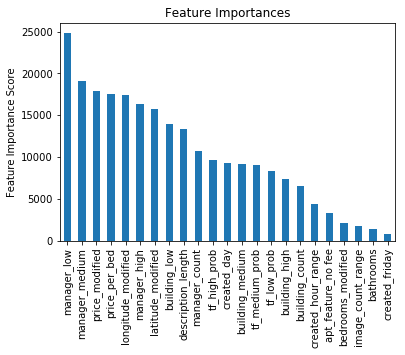

In [304]:
feat_imp = pd.Series(gb_model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

### kaggle score: 0.73656

## 4.7 SGD Classifier


In [263]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='modified_huber',penalty='l2',n_iter=300,class_weight='balanced',learning_rate='optimal')

gs_parameters = {'n_iter':[100,300,500]}

gs_sgd_model = GridSearchCV(sgd_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_sgd_model.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=300,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_iter': [100, 300, 500]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0)

In [264]:
describe_grid_model(gs_sgd_model,True)

CCV Score, Base Model Score: 0.639241692757 , 0.905593116751
0    {'n_iter': 100}
1    {'n_iter': 300}
2    {'n_iter': 500}
Name: params, dtype: object
0   -0.666612
1   -0.656782
2   -0.648176
Name: mean_test_score, dtype: float64


In [265]:
#saving model
with open('final_renthop_sgd.pkl', 'wb') as f:
    pickle.dump(gs_sgd_model, f)

#getting predictions
ccv = CalibratedClassifierCV(gs_sgd_model.best_estimator_,method="isotonic", cv="prefit")
ccv.fit(X_val,y_val) #fit to overall validation set
nb_kaggle_predictions = ccv.predict_proba(nn_kaggle_test)
#outputing predictions
output_predictions(nb_kaggle_predictions,"sgd")

        listing_id      high    medium       low
0          7142618  0.100518  0.255474  0.644008
1          7210040  0.020695  0.138293  0.841011
100        7103890  0.037359  0.182441  0.780201
1000       7143442  0.275641  0.386056  0.338303
100000     6860601  0.026237  0.268333  0.705430


### kaggle score: 0.65002

## 4.8 Adaboost
First GridSearch on DecisionTreeClassifier to fine tune it. Then RandomizedSearch to fine tune the AdaBoost model.

In [253]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_rand

dtc = DecisionTreeClassifier(class_weight='balanced')

ada_model = AdaBoostClassifier(
    dtc,
    n_estimators=50,
    learning_rate=1.0)

gs_parameters = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
                 "base_estimator__max_depth" : range(3,9,2),
                 "base_estimator__max_features":["auto",None]
             }

gs_ada_model = GridSearchCV(ada_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_ada_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'base_estimator__splitter': ['best', 'random'], 'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__max_depth': range(3, 9, 2), 'base_estimator__max_features': ['auto', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0)

In [255]:
describe_grid_model(gs_ada_model,True)

CCV Score, Base Model Score: 0.516917406143 , 0.837728278731
0     {'base_estimator__splitter': 'best', 'base_est...
1     {'base_estimator__splitter': 'random', 'base_e...
2     {'base_estimator__splitter': 'best', 'base_est...
3     {'base_estimator__splitter': 'random', 'base_e...
4     {'base_estimator__splitter': 'best', 'base_est...
5     {'base_estimator__splitter': 'random', 'base_e...
6     {'base_estimator__splitter': 'best', 'base_est...
7     {'base_estimator__splitter': 'random', 'base_e...
8     {'base_estimator__splitter': 'best', 'base_est...
9     {'base_estimator__splitter': 'random', 'base_e...
10    {'base_estimator__splitter': 'best', 'base_est...
11    {'base_estimator__splitter': 'random', 'base_e...
12    {'base_estimator__splitter': 'best', 'base_est...
13    {'base_estimator__splitter': 'random', 'base_e...
14    {'base_estimator__splitter': 'best', 'base_est...
15    {'base_estimator__splitter': 'random', 'base_e...
16    {'base_estimator__splitter': 'best', 

In [257]:
#print(gs_ada_model.cv_results_['params'])
print(gs_ada_model.best_estimator_)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)


In [258]:
dtc = DecisionTreeClassifier(class_weight='balanced',criterion='gini',splitter='best',max_depth=3,max_features=None)

ada_model = AdaBoostClassifier(
    dtc,
    n_estimators=100,
    learning_rate=1.0)

'''search_parameters = {'n_estimators':sp_randint(30,301),
                    'learning_rate':sp_randint(0,2)}'''

search_parameters = {'n_estimators':sp_randint(300,1001),
                    'learning_rate':sp_rand(.001,1.0)}

rs_ada_model = RandomizedSearchCV(ada_model,param_distributions=search_parameters,
                                  scoring=custom_ccv_scorer,cv=cv_sets,n_iter=20)
rs_ada_model.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000003536EB70>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000003536E940>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
          verbose=0)

In [260]:
describe_grid_model(rs_ada_model,True)

CCV Score, Base Model Score: 0.467816264238 , 0.980443885228
0     {'learning_rate': 0.79782021625, 'n_estimators...
1     {'learning_rate': 0.646144132692, 'n_estimator...
2     {'learning_rate': 0.487509747643, 'n_estimator...
3     {'learning_rate': 0.373236699566, 'n_estimator...
4     {'learning_rate': 0.45789264759, 'n_estimators...
5     {'learning_rate': 0.842987324563, 'n_estimator...
6     {'learning_rate': 0.211908149264, 'n_estimator...
7     {'learning_rate': 0.969526923624, 'n_estimator...
8     {'learning_rate': 0.0434287052497, 'n_estimato...
9     {'learning_rate': 0.55042017021, 'n_estimators...
10    {'learning_rate': 0.0658889965366, 'n_estimato...
11    {'learning_rate': 0.121478951209, 'n_estimator...
12    {'learning_rate': 0.926309223155, 'n_estimator...
13    {'learning_rate': 0.0274101532425, 'n_estimato...
14    {'learning_rate': 0.357365278038, 'n_estimator...
15    {'learning_rate': 0.986828879872, 'n_estimator...
16    {'learning_rate': 0.83460471761, 'n_e

In [261]:
#saving model
with open('final_renthop_ada.pkl', 'wb') as f:
    pickle.dump(rs_ada_model, f)

#getting predictions
ccv = CalibratedClassifierCV(rs_ada_model.best_estimator_,method="isotonic", cv="prefit")
ccv.fit(X_val,y_val) #fit to overall validation set
nb_kaggle_predictions = ccv.predict_proba(nn_kaggle_test)
#nb_kaggle_predictions = gs_knn_model.best_estimator_.predict_proba(nn_kaggle_test)

#outputing predictions
output_predictions(nb_kaggle_predictions,"ada")

        listing_id      high    medium       low
0          7142618  0.186254  0.342869  0.470877
1          7210040  0.000000  0.000000  1.000000
100        7103890  0.040376  0.275108  0.684517
1000       7143442  0.006255  0.275739  0.718006
100000     6860601  0.015904  0.256040  0.728056


In [262]:
for x,y in zip(rs_ada_model.best_estimator_.feature_importances_,X_train.columns.values):
    print(y,round(x,3))

bathrooms 0.005
bedrooms_modified 0.005
price_modified 0.096
price_per_bed 0.085
created_day 0.023
description_length 0.049
apt_feature_no fee 0.02
manager_count 0.015
manager_low 0.101
manager_medium 0.092
manager_high 0.089
building_count 0.014
building_low 0.056
building_medium 0.039
building_high 0.043
latitude_modified 0.092
longitude_modified 0.074
image_count_range 0.006
created_friday 0.001
created_hour_range 0.013
tf_low_prob 0.02
tf_medium_prob 0.031
tf_high_prob 0.03


### kaggle score of 2.01938

## 4.9 K Nearest Neighbors

In [246]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_model = KNeighborsClassifier(n_neighbors=5,weights='uniform',algorithm='auto')

#testing weights and p first
gs_parameters = {'weights':('uniform','distance'),'p':[1,2]}

gs_knn_model = GridSearchCV(knn_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_knn_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'p': [1, 2], 'weights': ('uniform', 'distance')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0)

In [247]:
describe_grid_model(gs_knn_model,True)

CCV Score, Base Model Score: 0.664731285745 , 2.64690908746
0     {'p': 1, 'weights': 'uniform'}
1    {'p': 1, 'weights': 'distance'}
2     {'p': 2, 'weights': 'uniform'}
3    {'p': 2, 'weights': 'distance'}
Name: params, dtype: object
0   -0.684538
1   -0.717288
2   -0.703128
3   -0.743472
Name: mean_test_score, dtype: float64


In [248]:
#uniform and p=1 the best parameters
#deciding on number of neighbors 
knn_model = KNeighborsClassifier(n_neighbors=5,weights='uniform',algorithm='auto',p=1)

gs_parameters = {'n_neighbors':[5,15,25]}

gs_knn_model = GridSearchCV(knn_model, param_grid=gs_parameters,scoring=custom_ccv_scorer,cv=cv_sets)
gs_knn_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 15, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0)

In [249]:
describe_grid_model(gs_knn_model,True)

CCV Score, Base Model Score: 0.627033297075 , 0.796548991942
0     {'n_neighbors': 5}
1    {'n_neighbors': 15}
2    {'n_neighbors': 25}
Name: params, dtype: object
0   -0.684538
1   -0.650430
2   -0.642740
Name: mean_test_score, dtype: float64


In [251]:
#saving model
with open('final_renthop_knn.pkl', 'wb') as f:
    pickle.dump(gs_knn_model, f)

#getting predictions
ccv = CalibratedClassifierCV(gs_knn_model.best_estimator_,method="isotonic", cv="prefit")
ccv.fit(X_val,y_val) #fit to overall validation set
nb_kaggle_predictions = ccv.predict_proba(nn_kaggle_test)
#nb_kaggle_predictions = gs_knn_model.best_estimator_.predict_proba(nn_kaggle_test)

#outputing predictions
output_predictions(nb_kaggle_predictions,"knn")

        listing_id      high    medium       low
0          7142618  0.126276  0.410624  0.463101
1          7210040  0.035900  0.072810  0.891291
100        7103890  0.009496  0.275372  0.715132
1000       7143442  0.227835  0.345687  0.426478
100000     6860601  0.009060  0.241428  0.749512


### kaggle score: 0.65466

## 4.10 Voting Classifier
Since the Adaboost model scored so poorly, I'm not including it in the Voting Classifier. The rest of the models are weighted equally.

In [305]:
from sklearn.ensemble import VotingClassifier
#rf: 0.78278; gs_rf_model.best_estimator_ 
#lr: 0.63189; gs_lr_model.best_estimator_
#knn: 0.65466; gs_knn_model.best_estimator_
#nb: 0.73364; bnb_model
#sgd: 0.65002; gs_sgd_model.best_estimator_
#gb: 0.73656; gb_model
#ada: 2.01938; rs_ada_model.best_estimator_ #('ada', rs_ada_model.best_estimator_)
#nn: 0.60874
#vc_model = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])

vc_model = VotingClassifier(estimators=[('rf', gs_rf_model.best_estimator_), ('lr', gs_lr_model), 
                                        ('knn', gs_knn_model.best_estimator_), ('gb', gb_model), 
                                        ('nb', bnb_model), ('sgd', gs_sgd_model)], 
                            voting='soft')

vc_model.fit(X_train,y_train)
vc_predictions = vc_model.predict_proba(X_test)
vc_score = log_loss(y_test,vc_predictions)
print(vc_score)

0.61931736473


In [306]:
#training model on full training set
vc_model.fit(nn_train,df_pre_train_label_vector)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=0.05, min_samples_split=2,
            min_weight_fr...n_score=True,
       scoring=<function custom_ccv_scorer at 0x0000000032B76840>,
       verbose=0))],
         n_jobs=1, voting='soft', weights=None)

In [308]:
#saving model
with open('final_renthop_vc.pkl', 'wb') as f:
    pickle.dump(vc_model, f)

#getting predictions
nb_kaggle_predictions = vc_model.predict_proba(nn_kaggle_text_xgb)

#outputing predictions
output_predictions(nb_kaggle_predictions,"vc")

        listing_id      high    medium       low
0          7142618  0.187493  0.429429  0.383078
1          7210040  0.129772  0.131496  0.738732
100        7103890  0.082758  0.343648  0.573594
1000       7143442  0.294752  0.462539  0.242709
100000     6860601  0.095749  0.432345  0.471906


### kaggle score: 0.68491

# 5.0 Conclusion
It's hard to know how to end a project such as this one as there is no correct or final answer. On my withheld test set, I can overfit several models (xgboost, neural net, and voting classifier) to a log loss much lower than what is on the kaggle leaderboard. However when I use that overfitted model on the kaggle test set I predictably score much lower. I can continue to fit and tune the most promising models and get better scores on kaggle but even that does not guarantee that the model is actually better. I may just be overfitting to the revealed portion of the kaggle test set and not actually generalizing well to the hidden portion of the kaggle test set. The best model I came up with was the feedforward neural net, followed by the second logistic regression model. The voting classifier for the second batch of models performed worse than the voting classifier for the first batch of models, despite the second version of most of my individual models performing better than their respective first versions.<br/>

While I learned many things by working on this dataset, the main discovery I had was how much there is to know and how many different directions solving a problem such as this one can take. As I worked on the project, I wrote a list of ideas to try and directions to explore. While I implemented and explored some of them, going through the entire list would take months at least and likely lead to many different techniques to try. It's also difficult to tell how successful each attempt is as there are a multitude of factors that can influence the measures of success. My experience here emphasizes to me the importance of pipelines, being able to make incremental changes, analyze the results, and then hopefully improve the model.<br/>